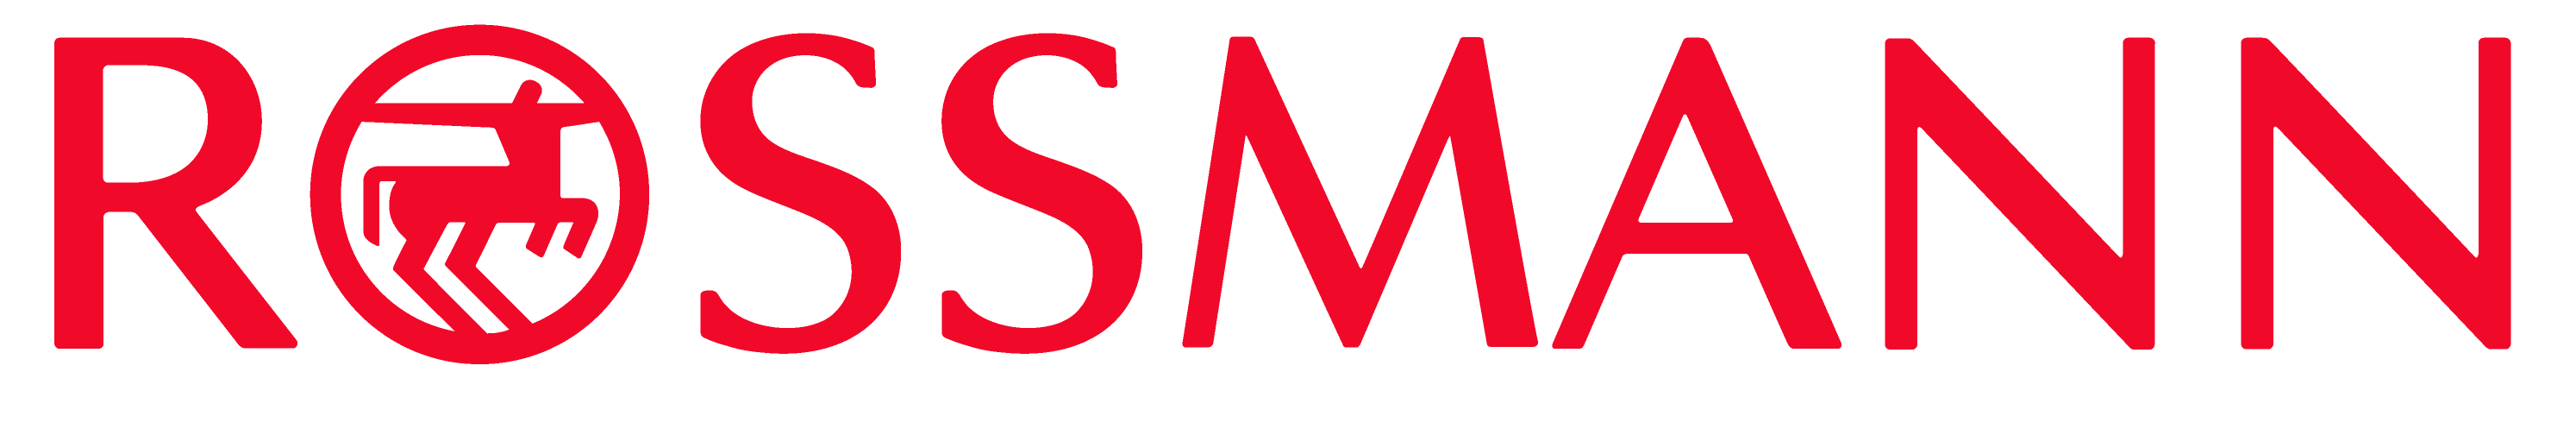

In [2]:
from IPython.display import Image
Image('img/Rossmann.png')

## Agenda

1. Contexto
2. Desafio
4. Desenvolvimento da Solução
5. Conclusão & Demonstr

# 1. Bussines

## 1.1 Contexto 

- Reunião Mensal de Resultados
- CFO pediu uma Previsão de Vendas das Próximas 6 semanas de cada Loja

## 1.2 Desafio

### Problema
- Definição do Budget para a Reforma das Lojas.

### Causas
- Predição de Vendas Atual apresentada muita Divergencia
- O processo de Predição de Vendas é baseado em Experiencias Passadas.
- Todo a Previsão de Vendas é feita Manualmente pelas 1.115 Lojas da Rossmann.
- A visualização das Vendas é Limitada ao Computador.

# 2. Configuration

## 2.1 Imports

In [75]:
import math
import time
import datetime
import inflection
import pickle
import json
import requests

import pandas                   as  pd
import numpy                    as  np
import seaborn                  as  sns 
import matplotlib.gridspec      as  gridspec
import xgboost                  as  xgb
import matplotlib.patches       as patches

from flask                      import Flask, request , Response
from skopt                      import BayesSearchCV
from matplotlib                 import  pyplot  as  plt
from scipy                      import  stats
from IPython.core.display       import  HTML
from IPython.display            import  Image
from watermark                  import  watermark
from sys                        import  displayhook
from sklearn.metrics            import  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection  import  RFE
from sklearn.preprocessing      import  RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble           import  RandomForestRegressor
from sklearn.ensemble           import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model       import  LinearRegression, Lasso
from sklearn.model_selection    import  TimeSeriesSplit, GridSearchCV
from api.rossmann.Rossmann import Rossmann



## 2.2 Functions

In [6]:
def mean_percentage_erro(y, yhat):
        return np.mean((y - yhat)/y)
    

def timeSeries_CV(X, y, model_name, model, kfold = 5, verbose = False):
        mae_list = []
        mape_list = []
        rmse_list = []
        tscv = TimeSeriesSplit(n_splits= kfold)
        for i, (train_index, test_index) in enumerate(tscv.split(X)):
                if verbose:
                        print(f"Fold {i+1}:")
                
                # model
                m = model.fit( X.iloc[train_index], y.iloc[train_index]  )

                # prediction
                yhat = m.predict(X.iloc[test_index])

                # performance
                m_result = ml_error( model_name, np.expm1( y.iloc[test_index] ), np.expm1( yhat ) )

                # store performance of each kfold iteration
                mae_list.append(  m_result['MAE'] )
                mape_list.append( m_result['MAPE'] )
                rmse_list.append( m_result['RMSE'] )

        return pd.DataFrame( {'Model Name': model_name,
                                'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                                'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                                'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {  'Model Name': model_name, 
                            'MAE': mae, 
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
        from scipy import stats  as ss
        cm = pd.crosstab( x, y ).values
        n = cm.sum()
        r, k = cm.shape
        
        chi2 = ss.chi2_contingency( cm )[0]
        chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
        
        kcorr = k - (k-1)**2/(n-1)
        rcorr = r - (r-1)**2/(n-1)
        
        return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    displayhook( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def summary_stats(df, index_target):
    # central tendency: mean, median   
    numerical_features = df.select_dtypes(include = ['number']).columns.values
    df = df[numerical_features]
    
    count_ = pd.DataFrame(df.apply(np.size))
    sum_ = pd.DataFrame(df.apply(np.sum))
    mean_ = pd.DataFrame(df.apply(np.mean))
    std_ = pd.DataFrame(df.apply(np.std))
    median_ = pd.DataFrame(df.apply(np.median))
    
    min_ = pd.DataFrame(df.apply(min))
    max_ = pd.DataFrame(df.apply(max))
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    q1_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,25)))
    q3_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,75)))
    
    skewness_= pd.DataFrame(df.apply(lambda x: x.skew()))
    kurtosis_ = pd.DataFrame(df.apply(lambda x: x.kurtosis()))
    
    summary = pd.concat([count_, mean_, std_, median_, sum_, min_, max_, range_, q1_,q3_, skewness_, kurtosis_],axis=1)
    summary.columns = ['counts', 'mean','std','median','sum','min','max', 'range', '25%','75%', 'skew', 'kurt']
 

    cm = sns.light_palette("#e76f51", as_cmap = True)
    
    display(summary.style.format('{:.2f}').background_gradient(subset=(summary.index[index_target],summary.columns[:]),cmap=cm))
    
    
    

def dist_sales(df):
        # Cálculo da skewness e kurtosis
        skewness = stats.skew(df['sales'])
        kurtosis = stats.kurtosis(df['sales'])

        # Texto para exibir as informações de skewness e kurtosis
        info_text = f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"


        # Criar a figura e os subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Gráfico de densidade de probabilidade (KDE)
        sns.histplot(df['sales'], kde=True, ax=axes[0])
        axes[0].set_title('KDE - Density Plot')
        axes[0].set_xlabel('Sales')
        axes[0].text(0.2, 0.85, info_text, transform=axes[0].transAxes,
                bbox=dict(facecolor='white', alpha=0.5))

        # Gráfico Q-Q (Quantile-Quantile)
        stats.probplot(df['sales'], dist='norm', plot=axes[1])
        axes[1].set_title('Q-Q Plot')
        axes[1].set_xlabel('Theoretical Quantiles')
        axes[1].set_ylabel('Sample Quantiles')
        axes[1].text(0.05, 0.85, info_text, transform=axes[1].transAxes,
                bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()  # Para melhorar a aparência da figura
        plt.show()
        return


## 2.3 Máquina

In [7]:
print(watermark())

Last updated: 2023-08-12T06:22:37.593902-03:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.13.2

Compiler    : MSC v.1934 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [8]:
print(watermark(packages="pandas,numpy,scikit-learn,xgboost,matplotlib,seaborn, inflection,scipy"))

pandas      : 2.0.1
numpy       : 1.24.3
scikit-learn: 1.2.2
xgboost     : 1.7.5
matplotlib  : 3.7.1
seaborn     : 0.12.2
 inflection : not installed
scipy       : 1.10.1



## 2.4 Configuração de Vizualização

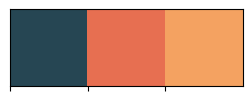

In [9]:
# Configurações de Layout, Matlab e Seaborn

LAYOUT_PALETTE = ["#264653","#e76f51","#f4a261"]
sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#e76f51")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

In [10]:
# Dimensionamendo do Dataframe

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 25)

# 3. Data Load

In [11]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)
df_test_raw = pd.read_csv('data/test.csv', low_memory=False)

# União das tabelas Sales e Store
df_train_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on = 'Store')
df_test_raw = pd.merge(df_test_raw, df_store_raw, how= 'left', on = 'Store')

In [12]:
df_train_raw.shape, df_test_raw.shape

((1017209, 18), (41088, 17))

# 3. Data Preprocessing

In [13]:
df3 = df_train_raw.copy() 

### 3.1 Rename Columns

In [14]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename

df3.columns = cols_new

### 3.2 Data Dimensions

In [15]:
print('Number of Rows: {}' .format(df3.shape[0]))
print('Number of Cols: {}' .format(df3.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 3.3 Data Types


In [16]:
df3['date'] = pd.to_datetime(df3['date'])
df3.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 3.4 Check NA

In [17]:
df3.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 3.5 Fillout NA

In [18]:
df3['promo_interval'].unique()


array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [19]:
#competition_distance
#Adicionando uma distancia muito grander para as linhas onde o valor é nulo, aqui estou considerando que o competidor esta tão longe que não era possivel medir sua distancia
# ou não era significante

df3['competition_distance'] = df3['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
# Considero os valores de mês para o inicio da concorrencia e que estejam nulo, começando no mês contido no resgitro da linha

df3['competition_open_since_month'] = df3[['competition_open_since_month' , 'date']].apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'],
                                                axis=1 )

#competition_open_since_year     
df3['competition_open_since_year'] = df3[['competition_open_since_year' , 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)                       

#promo2_since_week              
df3['promo2_since_week'] = df3[['promo2_since_week' , 'date']].apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year               
df3['promo2_since_year'] = df3[['promo2_since_year' , 'date']].apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x ['promo2_since_year'], axis= 1)

#promo_interval 
month_promo = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df3['promo_interval'].fillna(0, inplace= True)
df3['month_promo'] = df3['date'].dt.month.map(month_promo)
df3['is_promo'] = df3[['promo_interval', 'month_promo']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_promo'] in x['promo_interval'].split(',') else 0, axis =1) 

In [20]:
# Checando os dados faltantes novamente

df3.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_promo                     0
is_promo                        0
dtype: int64

## 3.6 Change Data Types

In [21]:
# competiton
df3['competition_open_since_month'] = df3['competition_open_since_month'].astype( int )
df3['competition_open_since_year'] = df3['competition_open_since_year'].astype( int )
    
# promo2
df3['promo2_since_week'] = df3['promo2_since_week'].astype( int )
df3['promo2_since_year'] = df3['promo2_since_year'].astype( int )

# 4. Data Description

In [22]:
df4 = df3.copy()

In [23]:
num_attributes = df4.select_dtypes(include= ['int64','int32', 'float64'])
cat_atributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 4.1 Numerical Atributes

In [24]:
summary_stats(df4, index_target= 2)

,counts,mean,std,median,sum,min,max,range,25%,75%,skew,kurt
store,1017209.00,558.43,321.91,558.00,568039744.00,1.00,1115.00,1114.00,280.00,838.00,-0.00,-1.20
day_of_week,1017209.00,4.00,2.00,4.00,4067148.00,1.00,7.00,6.00,2.00,6.00,0.00,-1.25
sales,1017209.00,5773.82,3849.92,5744.00,5873180623.00,0.00,41551.00,41551.00,3727.00,7856.00,0.64,1.78
customers,1017209.00,633.15,464.41,609.00,644041755.00,0.00,7388.00,7388.00,405.00,837.00,1.60,7.09
open,1017209.00,0.83,0.38,1.00,844392.00,0.00,1.00,1.00,1.00,1.00,-1.76,1.09
promo,1017209.00,0.38,0.49,0.00,388080.00,0.00,1.00,1.00,0.00,1.00,0.49,-1.76
school_holiday,1017209.00,0.18,0.38,0.00,181721.00,0.00,1.00,1.00,0.00,0.00,1.68,0.82
competition_distance,1017209.00,5935.44,12547.65,2330.00,6037585710.00,20.00,200000.00,199980.00,710.00,6910.00,10.24,147.79
competition_open_since_month,1017209.00,6.79,3.31,7.00,6903644.00,1.00,12.00,11.00,4.00,10.00,-0.04,-1.23
competition_open_since_year,1017209.00,2010.32,5.52,2012.00,2044920520.00,1900.00,2015.00,115.00,2008.00,2014.00,-7.24,124.07


### 4.2. Categorical Atributes

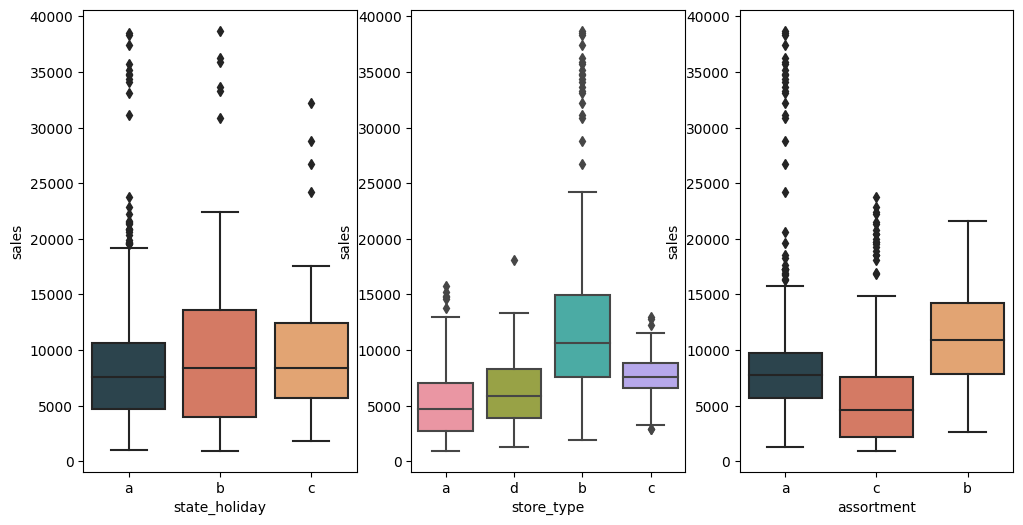

In [25]:
aux = df4[(df4['state_holiday'] != '0') & (df4['sales'] > 0)]

plt.figure(figsize= (12,6))
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )
plt.show()

# 5. Feature Engeneering 

In [26]:
df5 = df4.copy()

### 5.1 Mapa Mental de Hipoteses

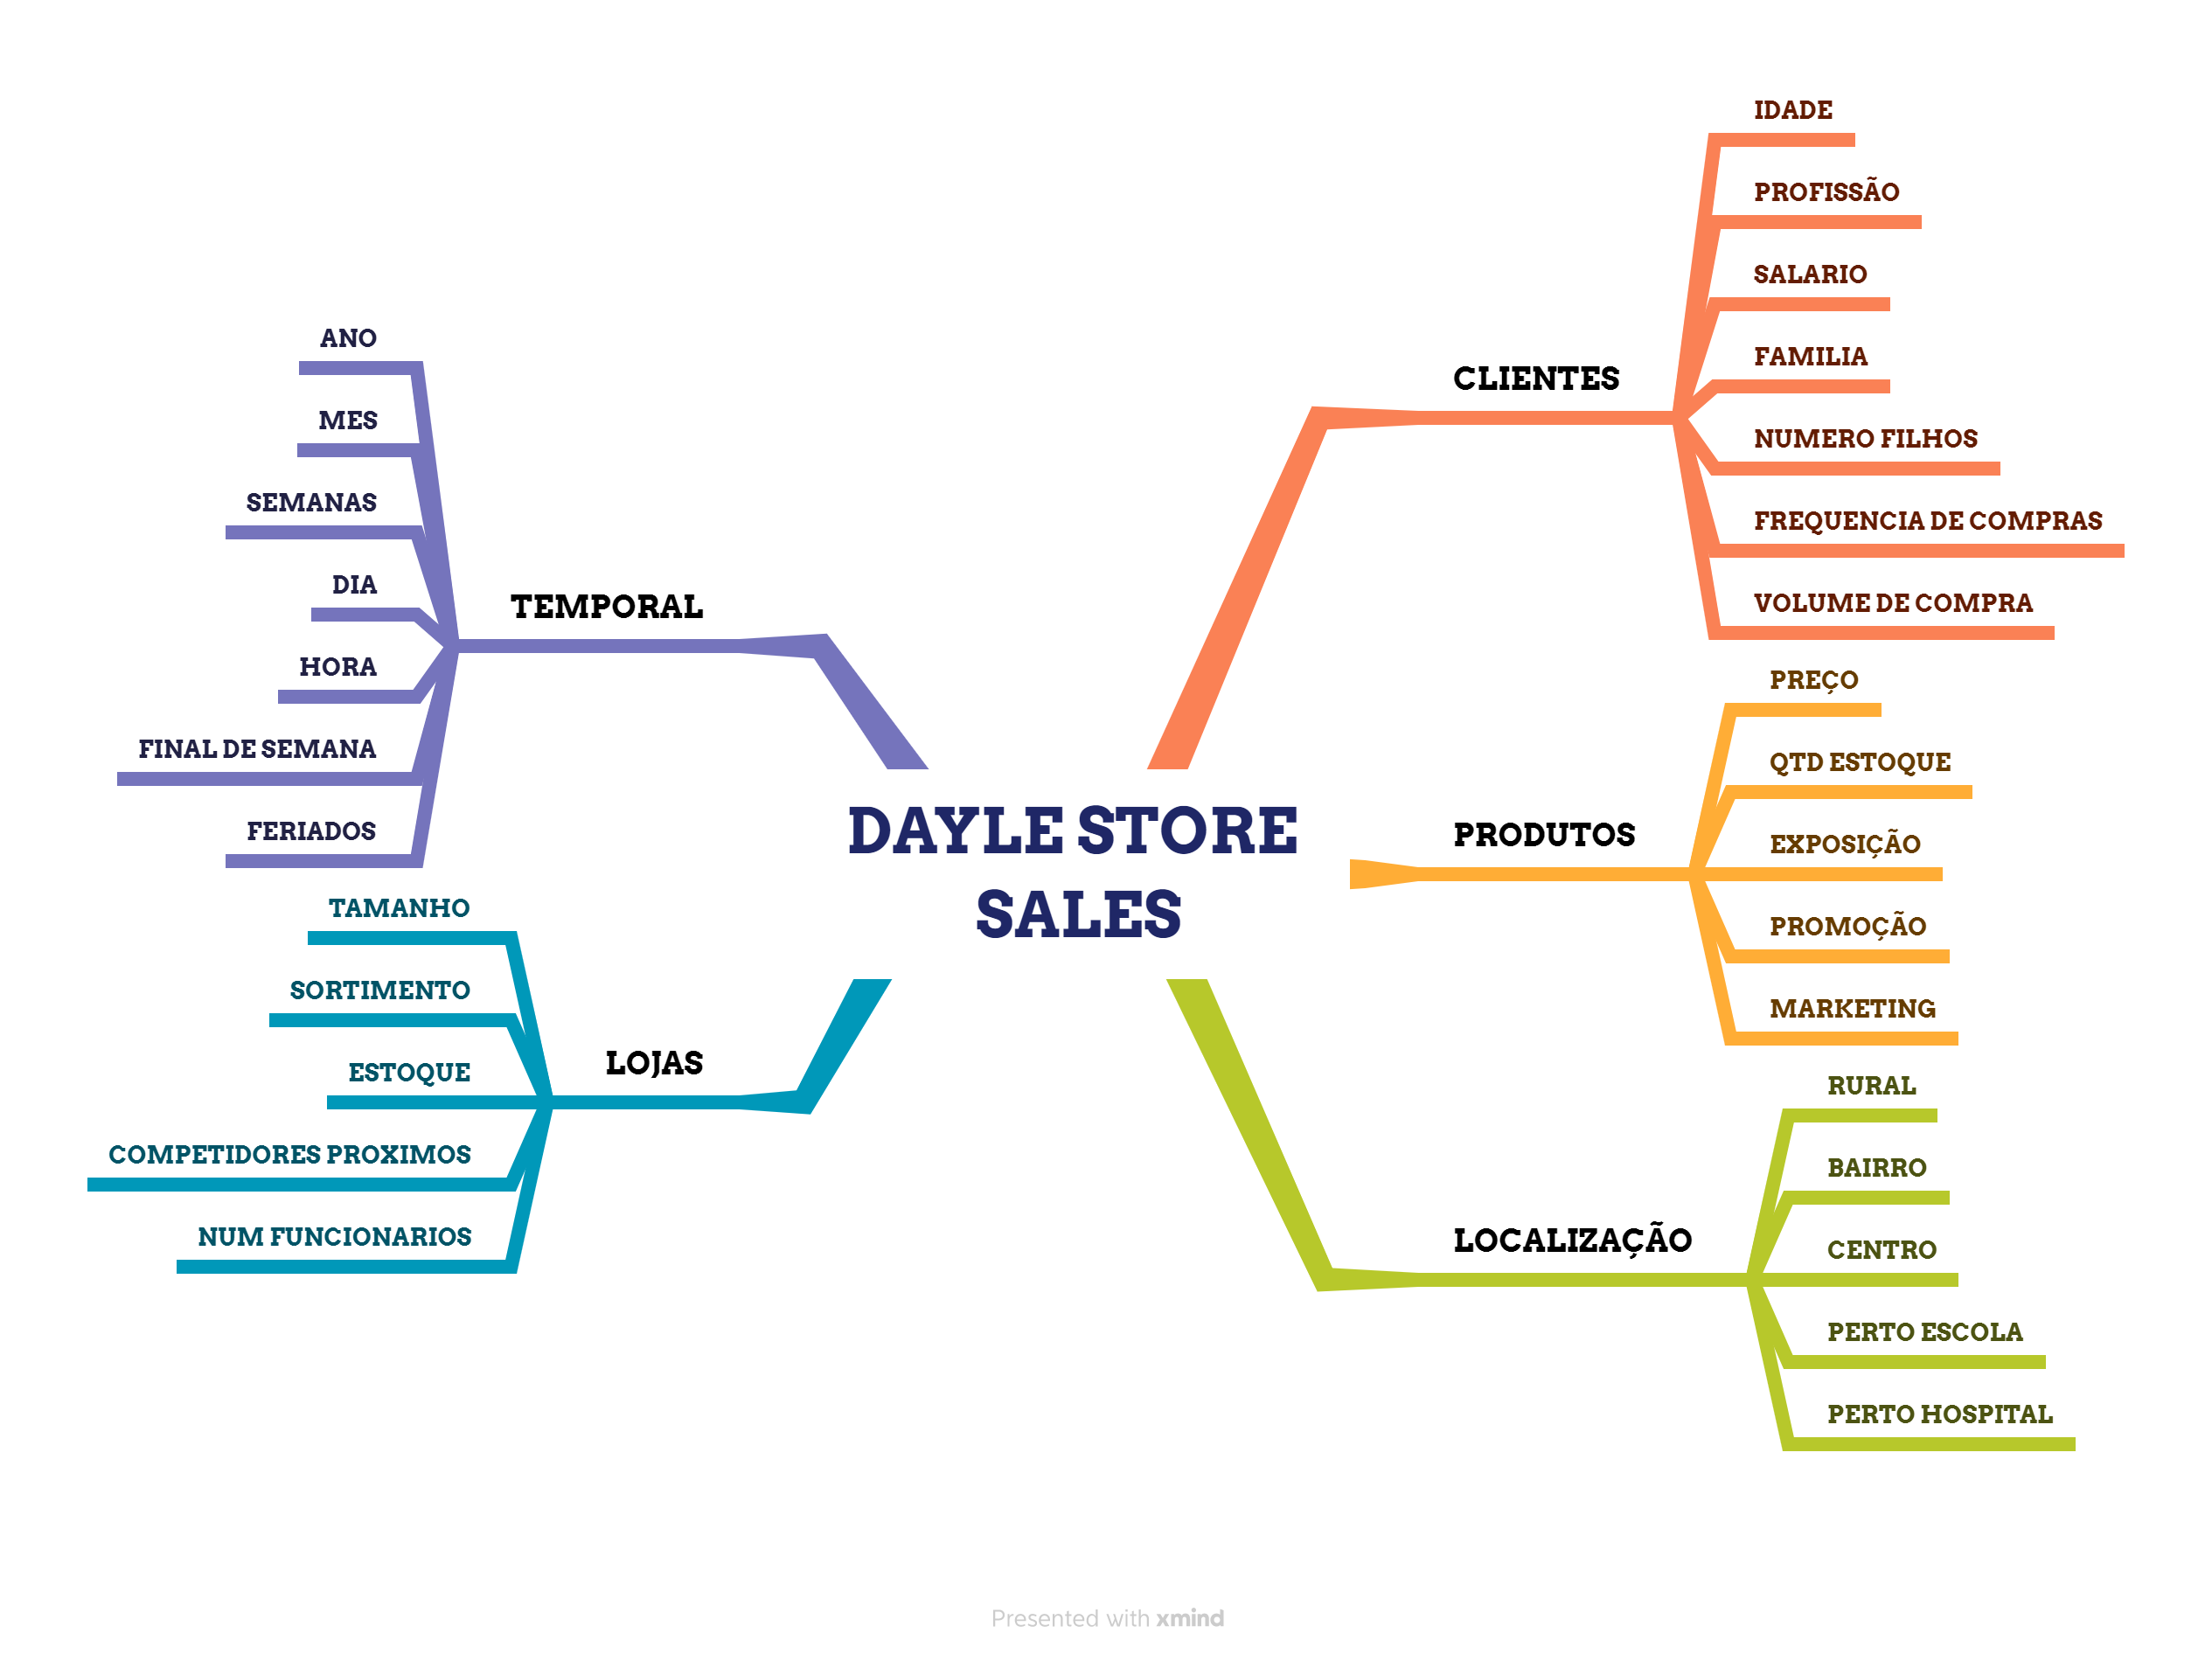

In [27]:
Image('img/mindmap.png')

### 5.2. Criaçao das Hipoteses

#### 5.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### 5.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 5.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


### 5.4. Feature Engineering

In [28]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_promo                             object
is_promo                                 int64
dtype: object

In [29]:
# Para validar as hipoteses levantadas eu preciso de criar novas colunas em meu dataset

# year
df5['year'] = df5['date'].dt.year

# month
df5['month'] = df5['date'].dt.month

# day
df5['day'] = df5['date'].dt.day

# week of year
df5['week_of_year'] = df5['date'].dt.isocalendar().week

# year week
df5['year_week'] = df5['date'].dt.strftime( '%Y-%W' )

# competition since
df5['competition_since'] = df5.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df5['competition_time_month'] = ((df5['date'] - df5['competition_since']) / 30).apply(lambda x: x.days if x.days > 0 else 0).astype(int)

# promo since
df5['promo_since'] = df5['promo2_since_year'].astype( str ) + '-' + df5['promo2_since_week'].astype( str )
df5['promo_since'] = df5['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df5['promo_time_week'] = ( ( df5['date'] - df5['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df5['assortment'] = df5['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df5['state_holiday'] = df5['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# 6. Filtragem das Variaveis 

In [30]:
df6 = df5.copy()

### 6.1. Filtragem das Linhas

In [31]:
# Quero apenas dados onde a loja esta aberta e que valor de vendas seja maior que 0
df6 = df6[(df6['open'] != 0) & (df6['sales'] > 0)]


### 6.2. Selecao das Colunas

In [32]:
# Excluir colunas na qual eu não terei durante o processo de previsão
cols_drop = ['customers', 'open', 'promo_interval', 'month_promo']
df6 = df6.drop( cols_drop, axis=1 )

# 7. Exploratory Data Analysis

In [33]:
df7 = df6.copy()

### 7.1. Analise Univariada

#### 7.1.1 Variavel Target

- Podemos ver que nossa varável target não é uma distribuição normal

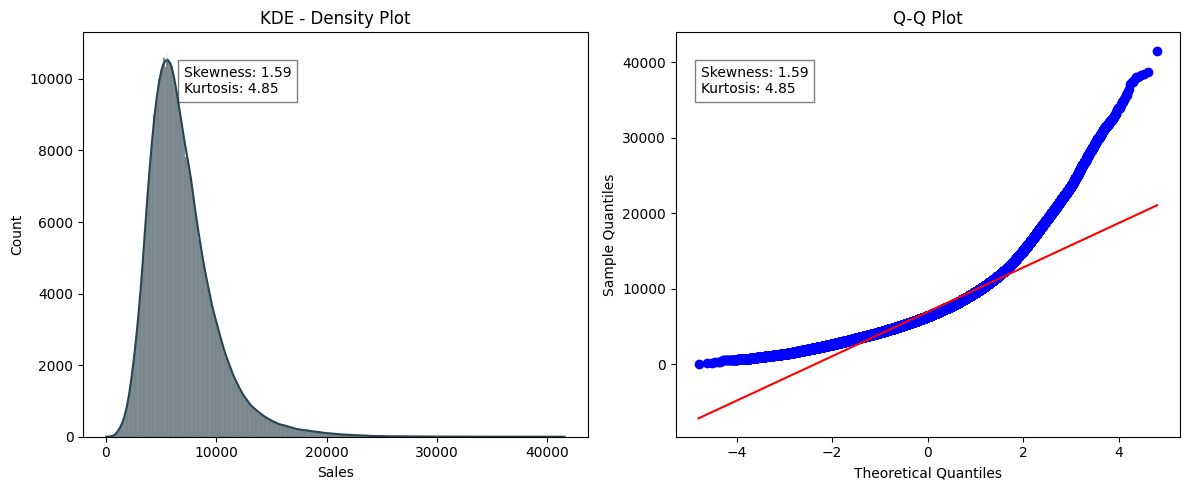

In [34]:
# Distribuição da variavel target
dist_sales(df7)

#### 7.1.2 Variaveis Numérica

In [35]:
df7.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

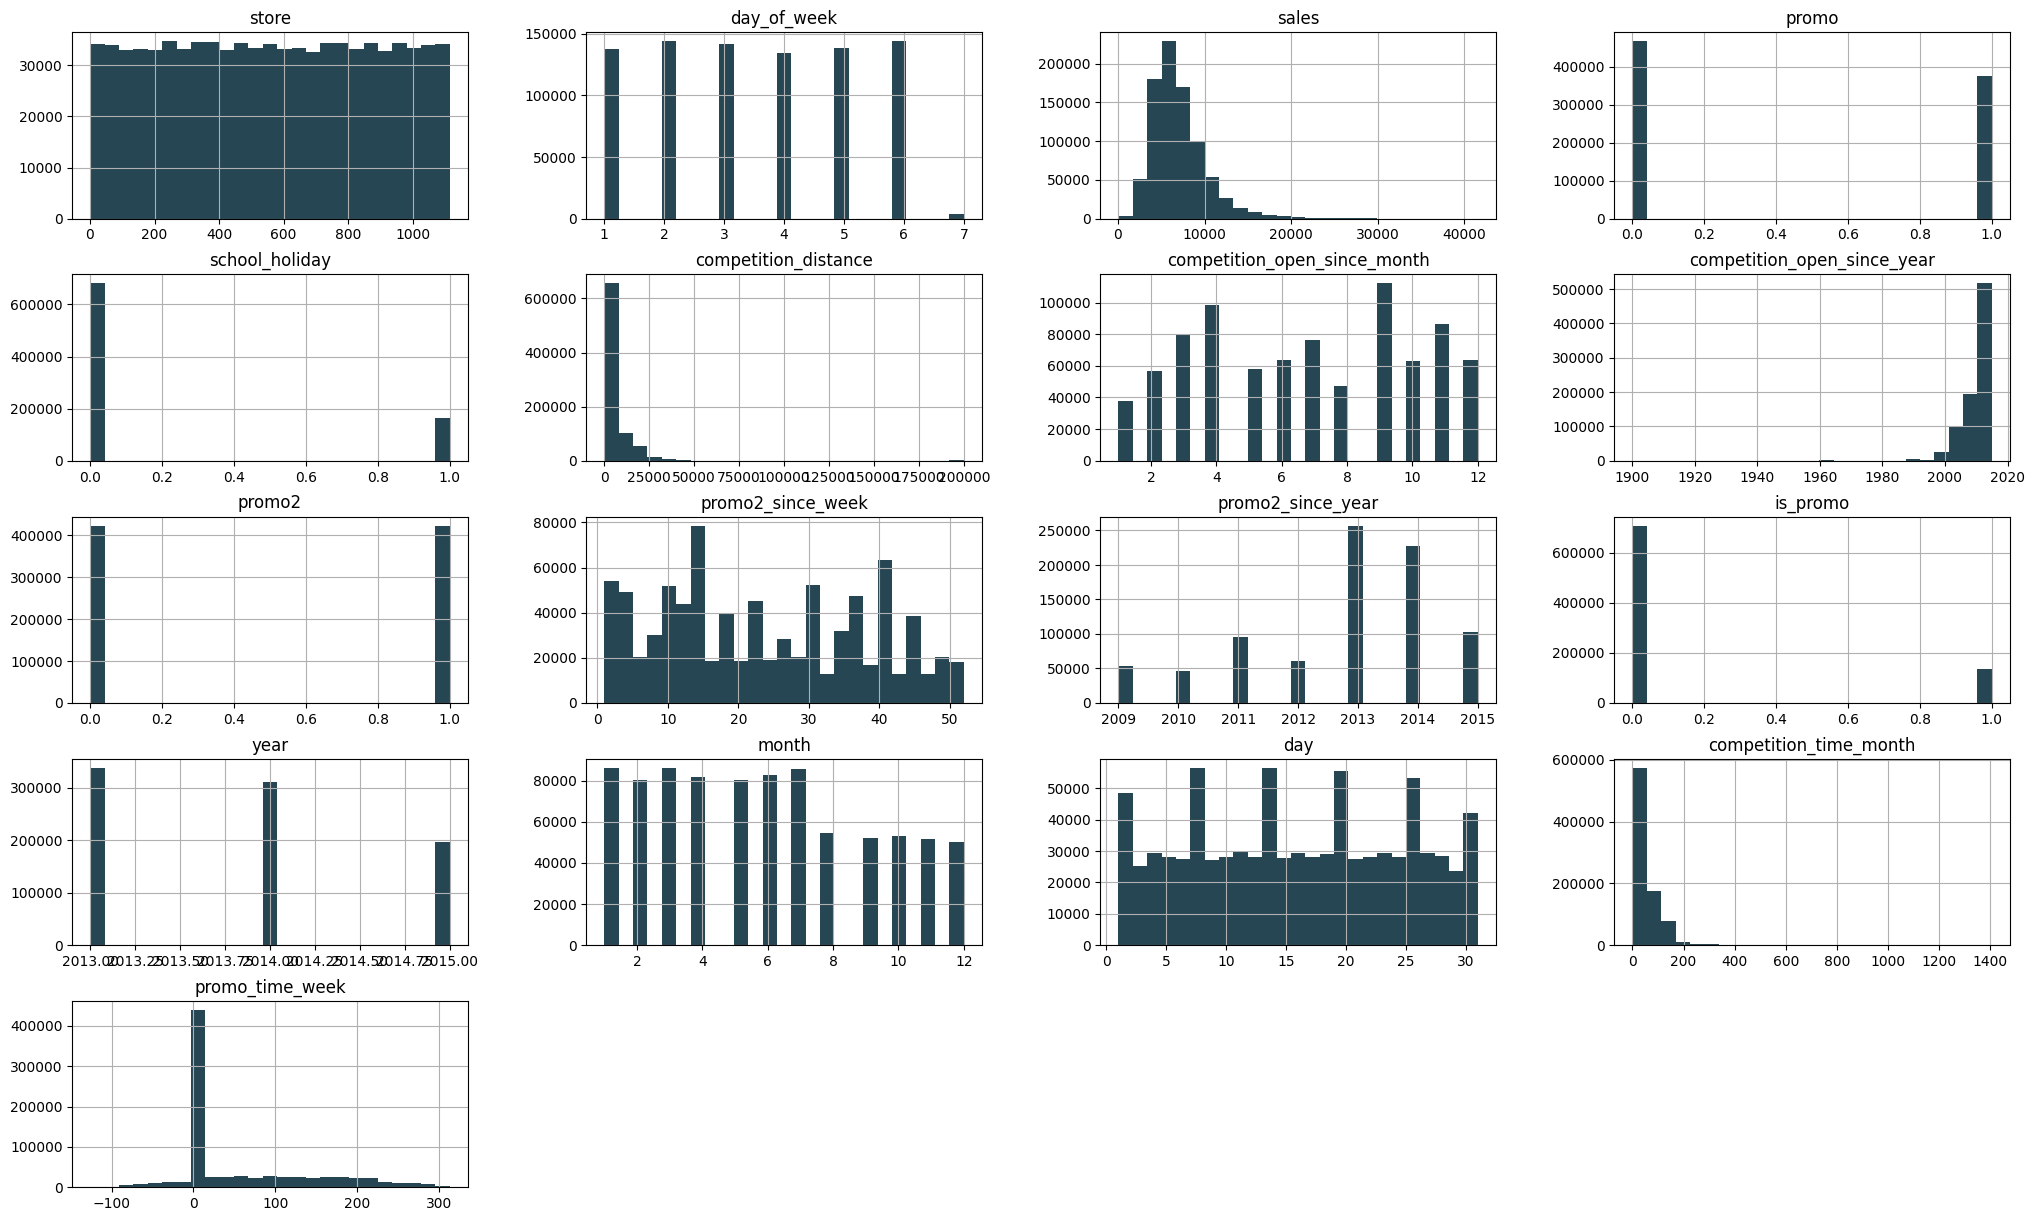

In [36]:
num_atributes = df7.select_dtypes(include= ['int32','int64', 'float64'])


num_atributes.hist(bins = 25, figsize= (25,15))
plt.show()

#### 7.1.2 Variaveis Categóricas

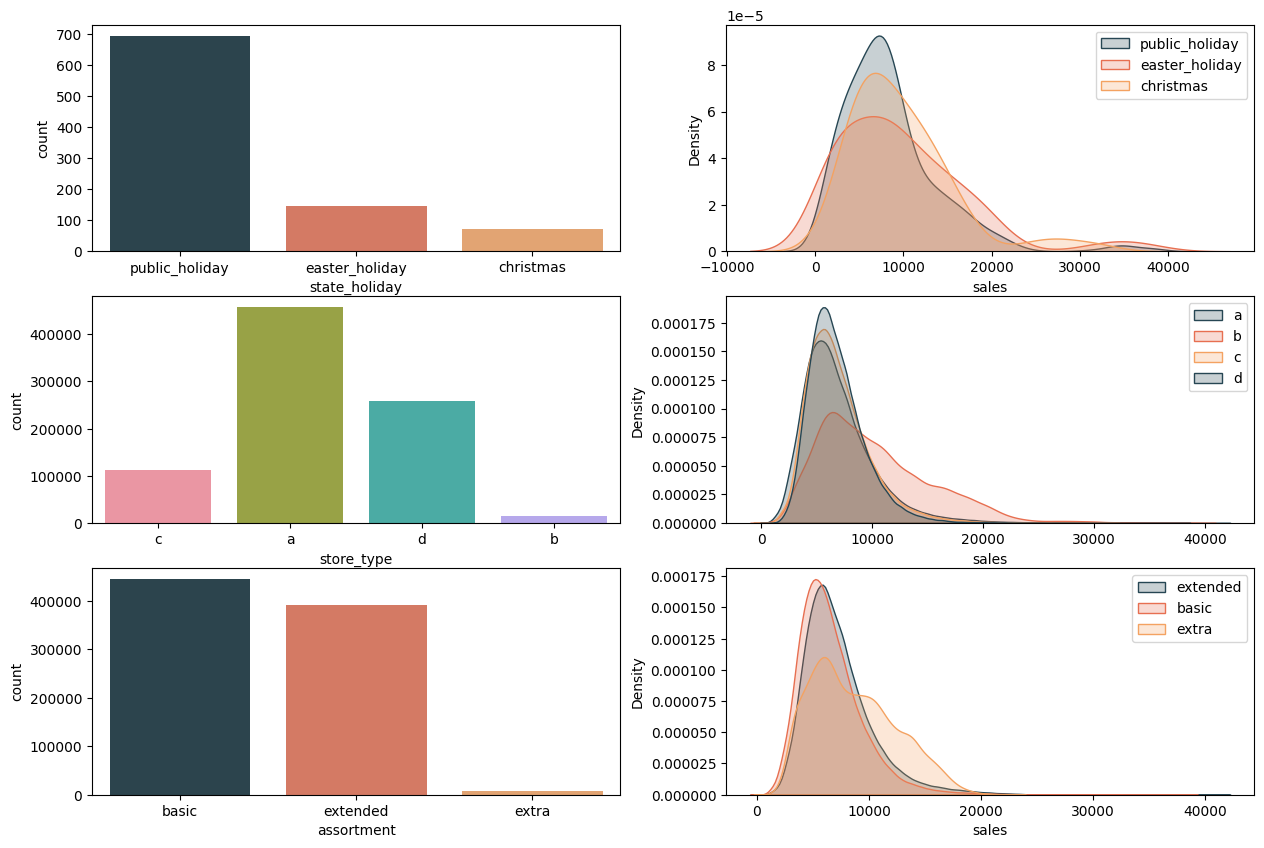

In [37]:
# state_holiday
plt.figure(figsize= (15,10))
plt.subplot( 3, 2, 1 )
a = df7[df7['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')


plt.subplot( 3, 2, 2 )
sns.kdeplot( df7[df7['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df7[df7['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df7[df7['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )
plt.legend()
# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(data =  df7, x = 'store_type' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df7[df7['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df7[df7['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df7[df7['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df7[df7['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()
# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data = df7, x = 'assortment' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df7[df7['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df7[df7['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df7[df7['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()
plt.show()


### 7.1. Analise Bivariada

#### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

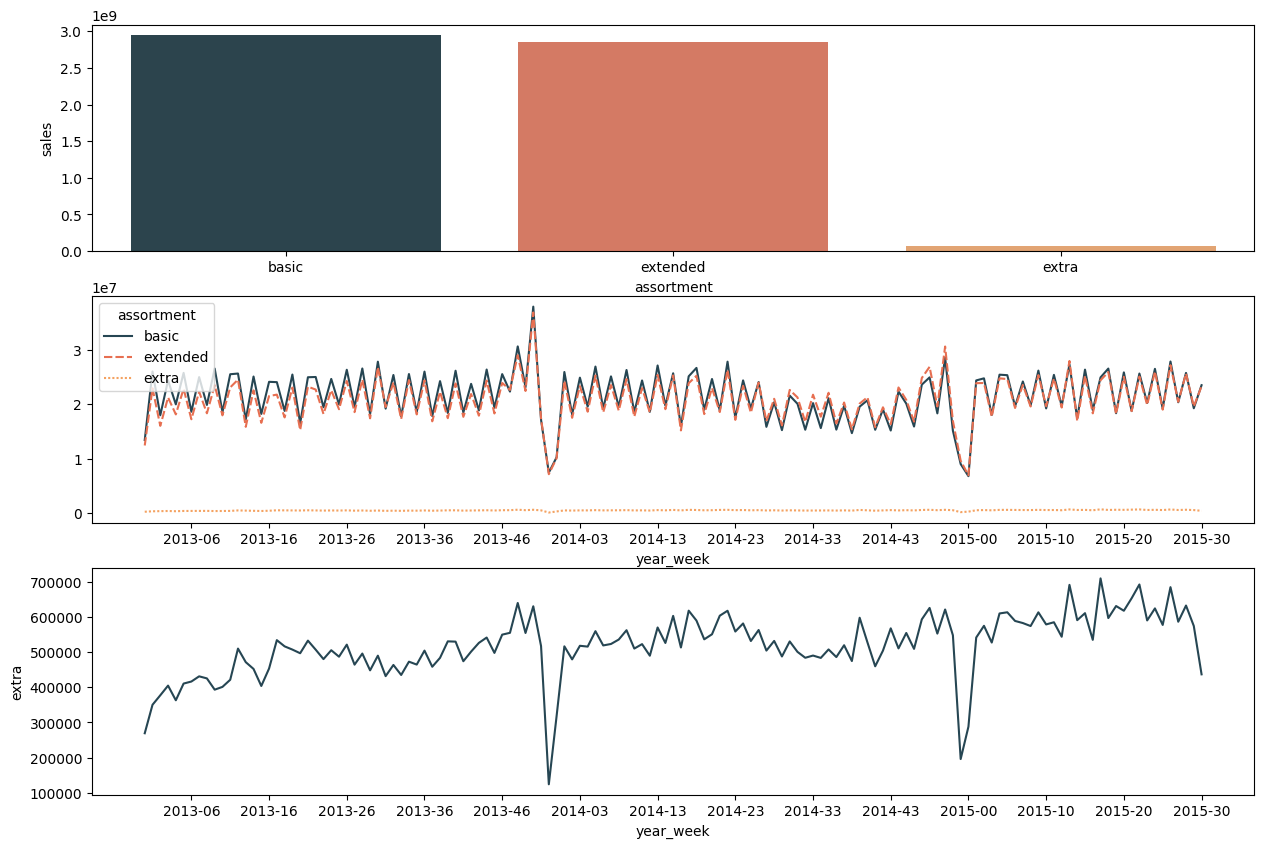

In [38]:

#dados
aux1 = df7[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
aux2 = df7[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux3 = aux2[aux2['assortment'] == 'extra']
aux2 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3  = aux3.pivot( index='year_week', columns='assortment', values='sales' )

eixo_x = df7['year_week'].unique()


plt.figure(figsize= (15,10))
plt.subplot(3,1,1)
sns.barplot( x='assortment', y='sales', data=aux1 )

plt.subplot(3,1,2)
sns.lineplot(aux2, )
plt.xticks(eixo_x[0:len(eixo_x):10])

plt.subplot(3,1,3)
sns.lineplot(data = aux3, x = aux3.index, y = aux3.extra)
plt.xticks(eixo_x[0:len(eixo_x):10])

# Rotacionar os valores do eixo x em 45 graus

plt.show()


#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

(2.5, -0.5)

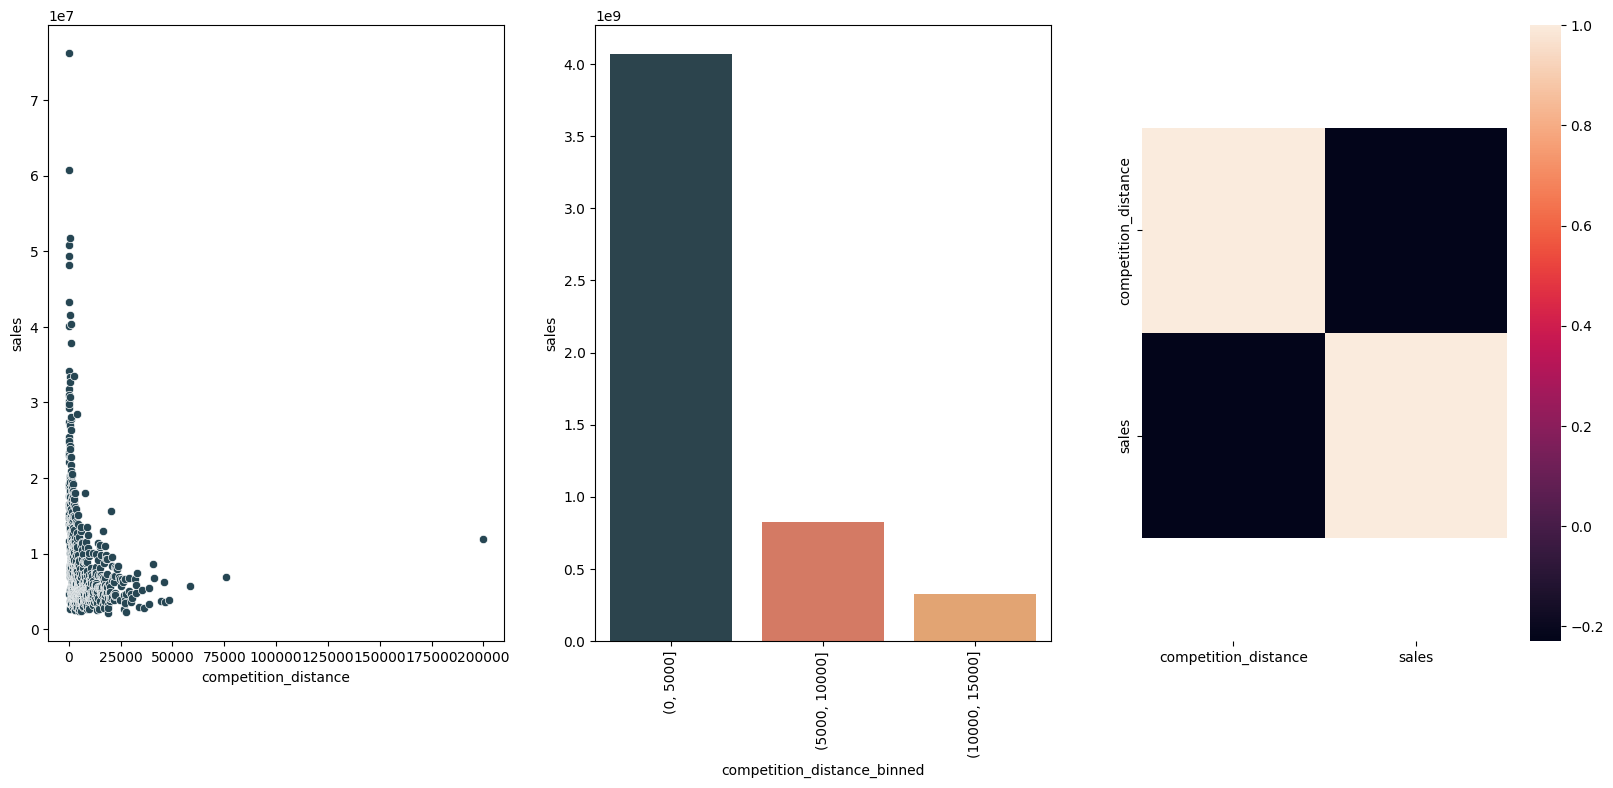

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.figure(figsize= (20,8))
# Converter colunas com Interval para strings
aux1['competition_distance'] = aux1['competition_distance'].astype(float)
aux1['sales'] = aux1['sales'].astype(float)

# Plotar o heatmap
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 5000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 )
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1[['competition_distance', 'sales']].corr( method='pearson' ) )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5)


#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

(2.5, -0.5)

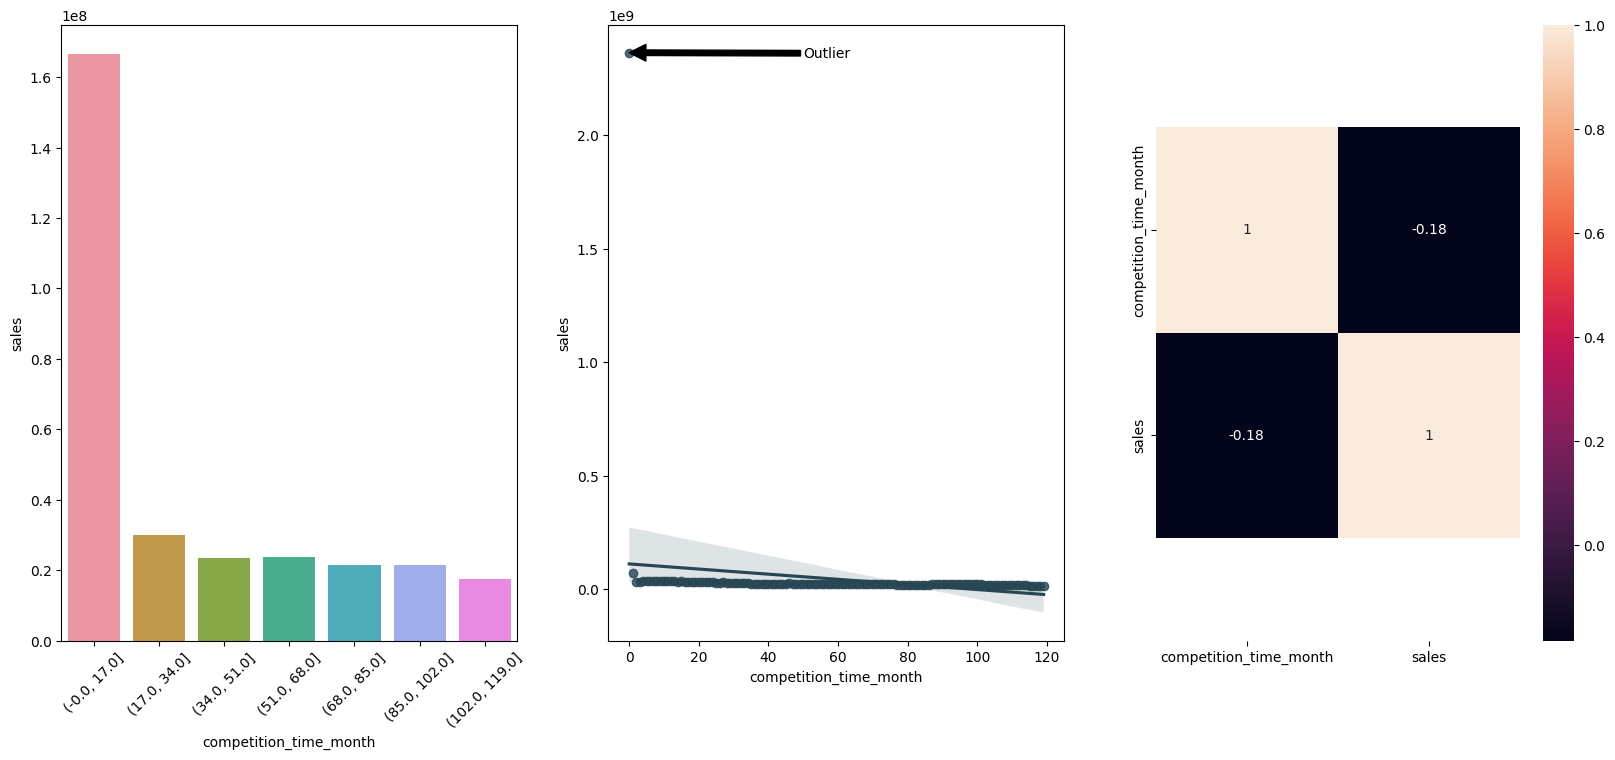

In [38]:
plt.figure(figsize= (20,8))

#Grafico 1
plt.subplot( 1, 3, 1 )
aux1 = df7[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 )]

# Barplot

    # Definir o número de intervalos
num_intervals = 7
    # Criar os intervalos para agrupamento
intervalos = pd.cut(aux2['competition_time_month'], bins=num_intervals, precision=0)

    # Agrupar os dados por intervalo e calcular a média das vendas

dados_agrupados = aux2.groupby(intervalos)['sales'].mean().reset_index()
sns.barplot( x='competition_time_month', y='sales', data=dados_agrupados)
plt.xticks(rotation = 45)




#Grafico 2
plt.subplot( 1, 3, 2 )

# Regressão entre sales e competition_time_month

sns.regplot( x='competition_time_month', y='sales', data=aux2 )

    # Índice do ponto ao qual você deseja adicionar a anotação
ponto_anotacao = 0

    # Coordenadas do ponto e do texto da anotação
x_ponto = aux2['competition_time_month'].iloc[ponto_anotacao]
y_ponto = aux2['sales'].iloc[ponto_anotacao]
texto_anotacao = f'Outlier'

    # Adicionar a anotação com uma seta e um texto
plt.annotate(texto_anotacao, (x_ponto, y_ponto), xytext=(x_ponto + 50, y_ponto - 20000000),
             arrowprops=dict(facecolor='black', shrink=0.0001))



# Grafico 3
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux2.corr( method='pearson'), annot=True )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5)

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

<Axes: >

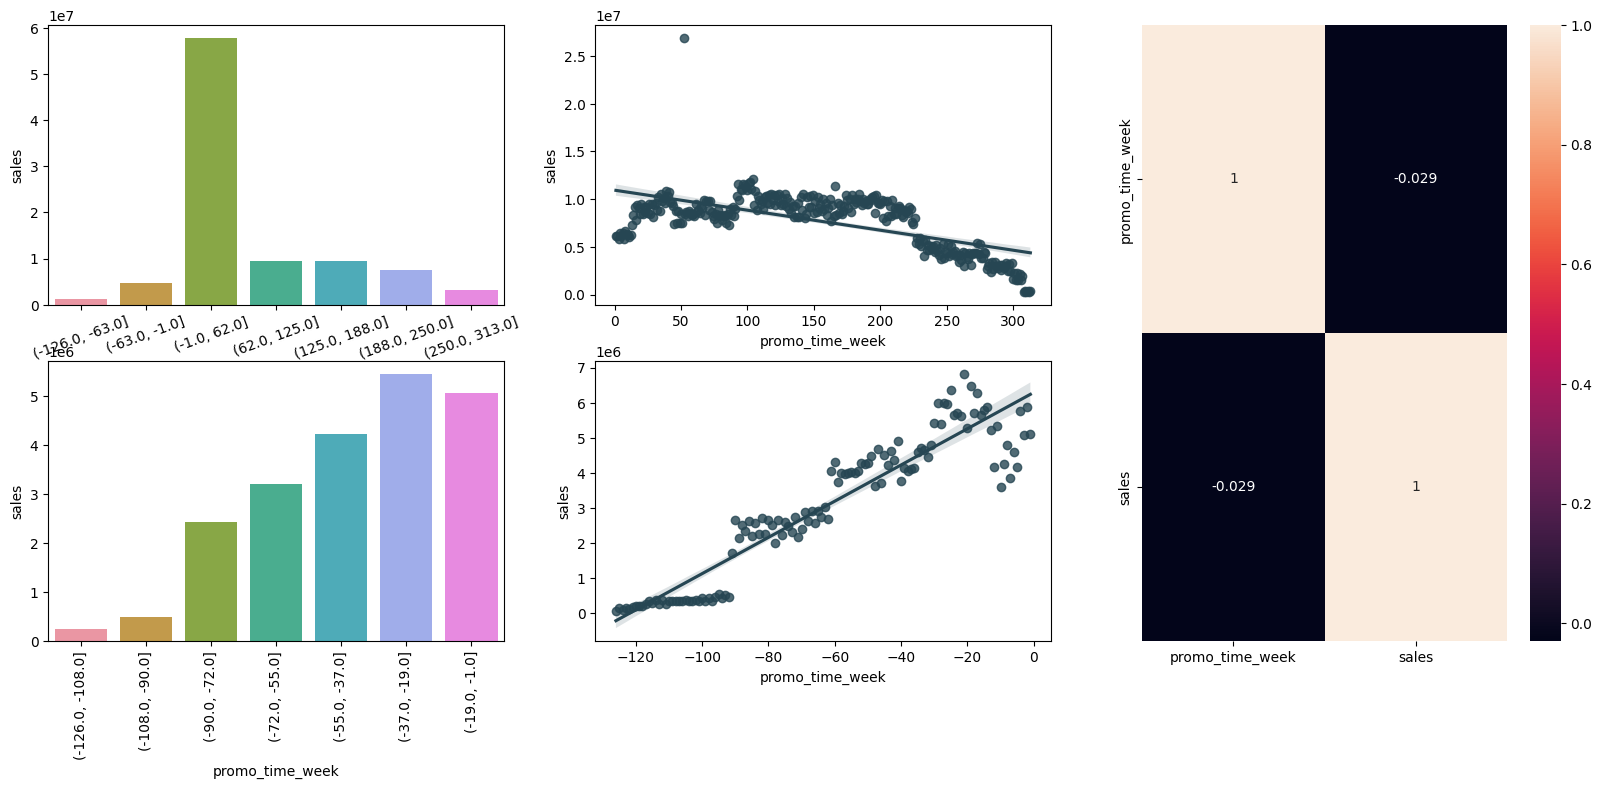

In [39]:
plt.figure(figsize= (20,8))
aux1 = df7[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = gridspec.GridSpec(2, 3)

#Grafico 1
plt.subplot(grid[0, 0])

# Criar os intervalos para agrupamento
intervalos = pd.cut(aux1['promo_time_week'], bins=7, precision=0)

# Agrupar os dados por intervalo e calcular a média das vendas

dados_agrupados = aux1.groupby(intervalos)['sales'].mean().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=dados_agrupados )
plt.xticks( rotation=20 )


#Grafico 2
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 )


#Grafico 3

plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

# Criar os intervalos para agrupamento
intervalos = pd.cut(aux3['promo_time_week'], bins=7, precision=0)

# Agrupar os dados por intervalo e calcular a média das vendas

dados_agrupados = aux3.groupby(intervalos)['sales'].mean().reset_index()
sns.barplot( x='promo_time_week', y='sales', data=dados_agrupados )
plt.xticks( rotation=90 )


#Grafico 4
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 )


#Grafico 5
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

#### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

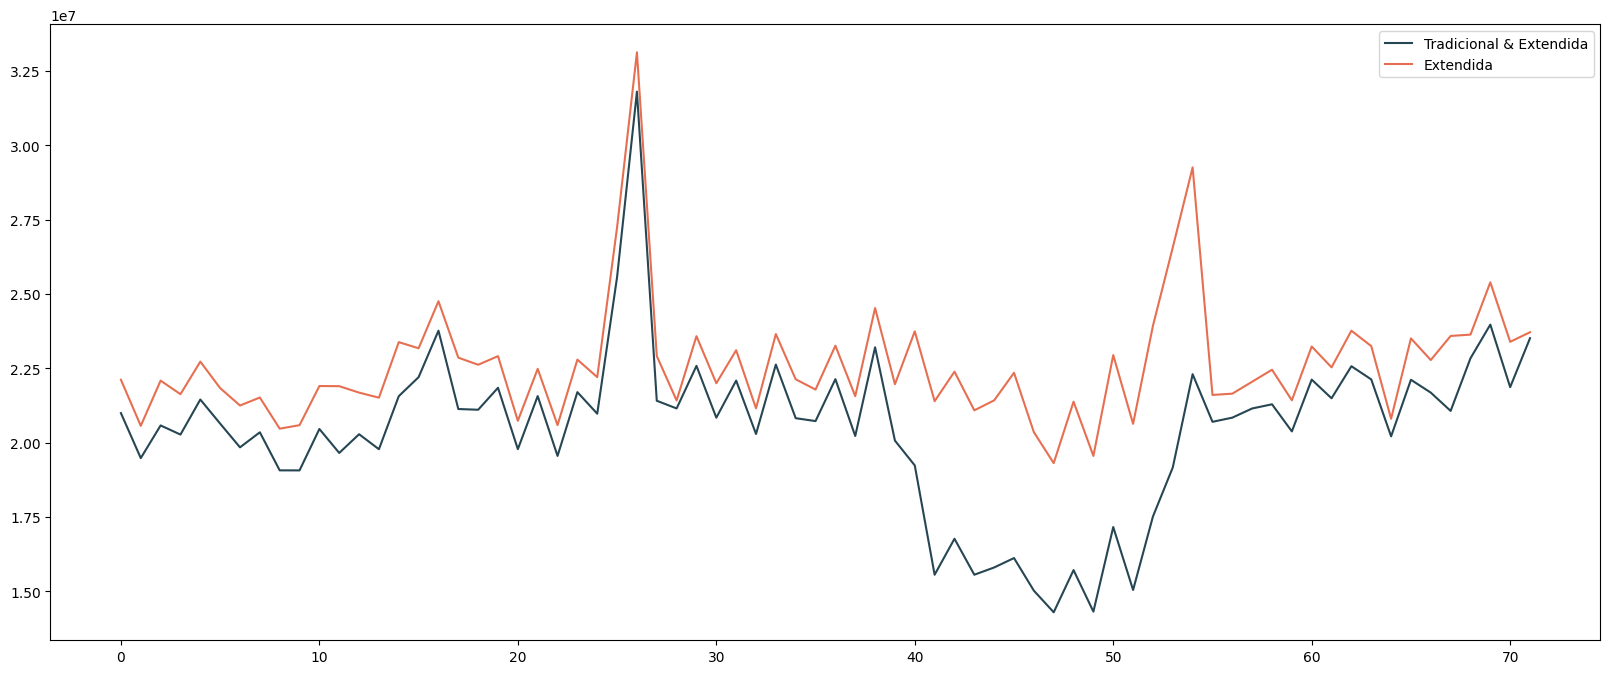

In [40]:
aux1 = df7[( df7['promo'] == 1 ) & ( df7['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot(figsize=(20,8))

aux2 = df7[( df7['promo'] == 1 ) & ( df7['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'])
plt.show()

#### **H6.** Lojas abertas durante o feriado de Natal deveriam vender em média mais que os demais feriados.
**Verdadeira** Lojas abertas durante o feriado do Natal vendem mais.

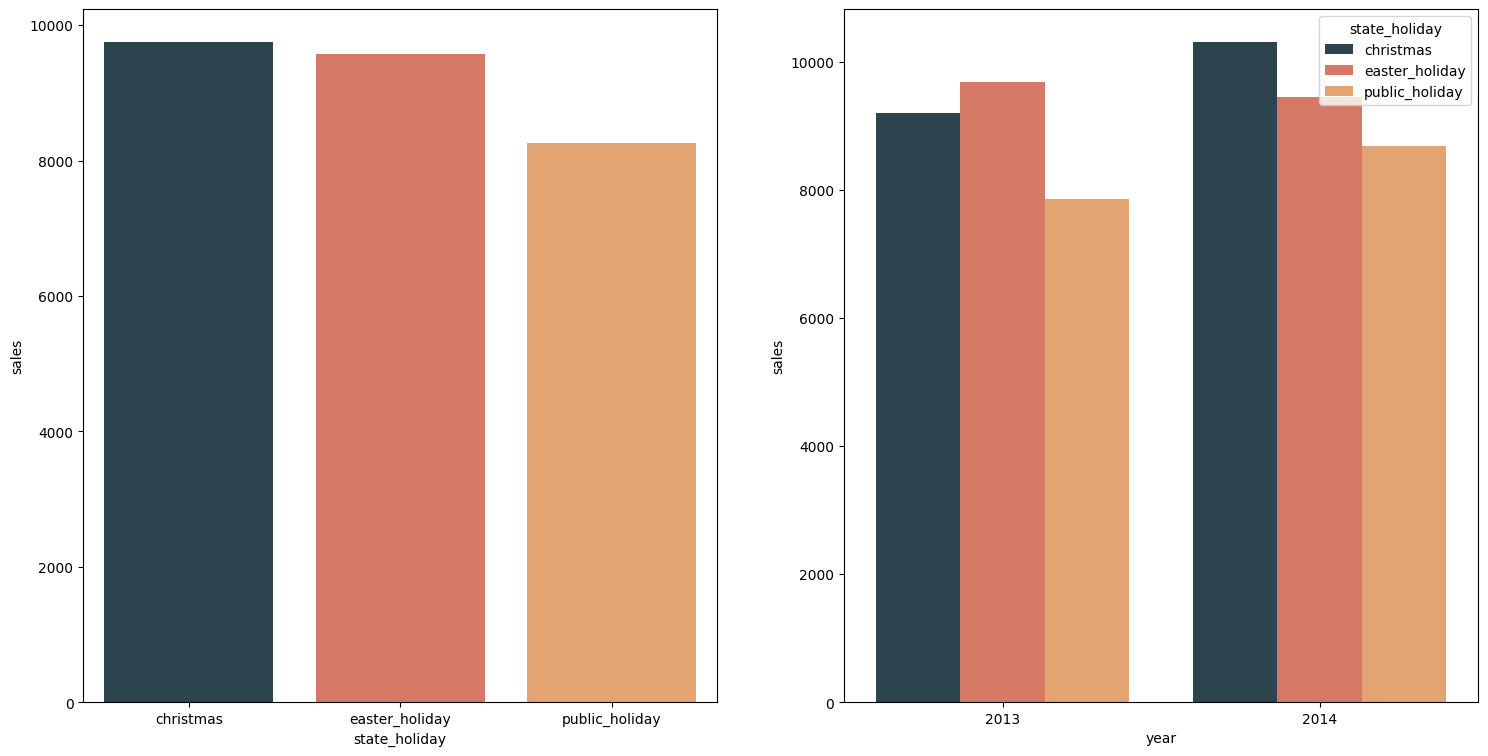

In [41]:
plt.figure(figsize= (18,9))

aux = df7[(df7['state_holiday'] != 'regular_day') & (df7['year'] < 2015)]
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
aux2  = aux2[aux2['year']<2015]
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 )

plt.show()

#### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

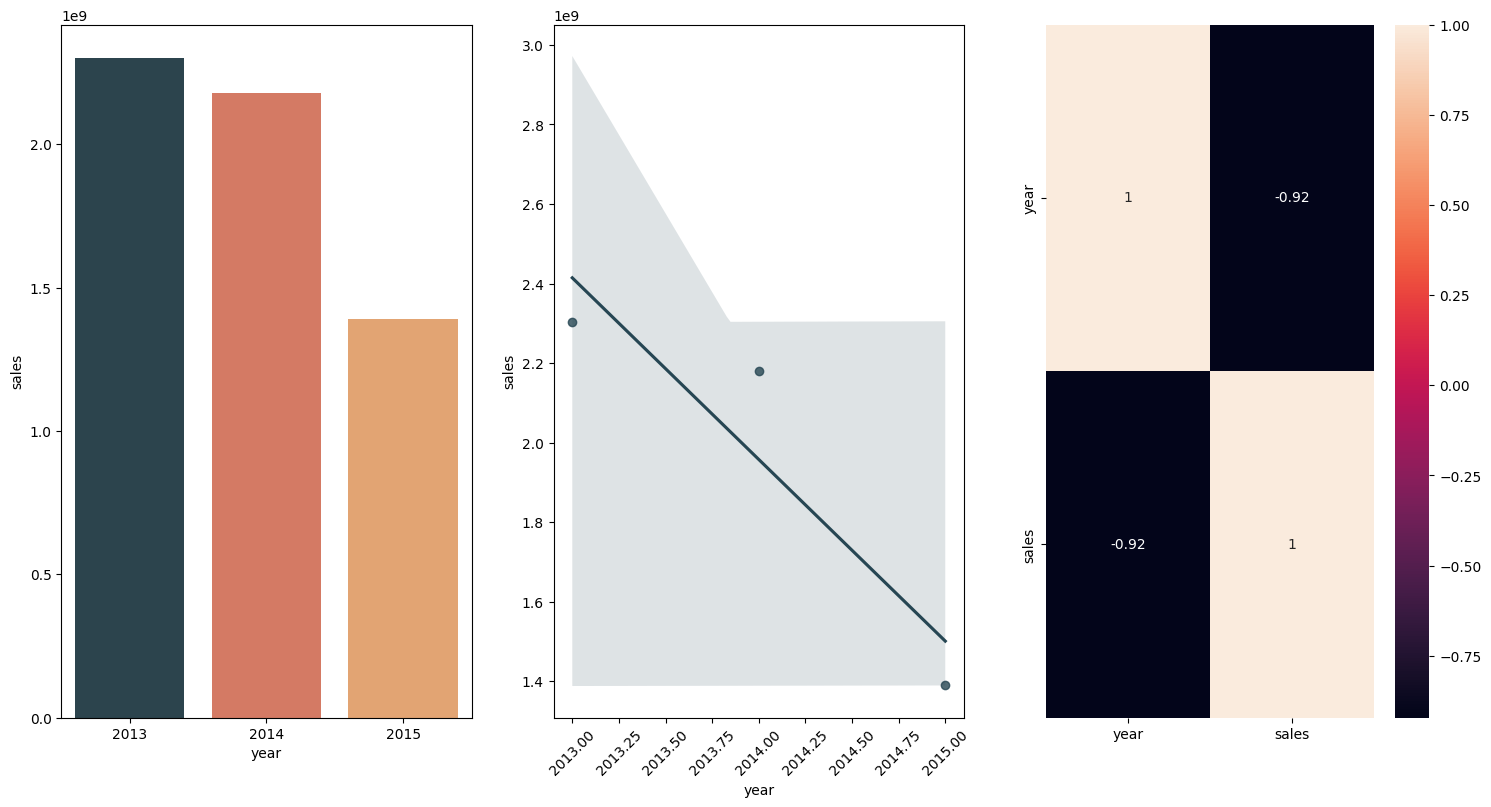

In [42]:
plt.figure(figsize= (18,9))
aux1 = df7[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )
plt.xticks(rotation = 45)

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

plt.show()

#### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem mais no segundo semestre do ano

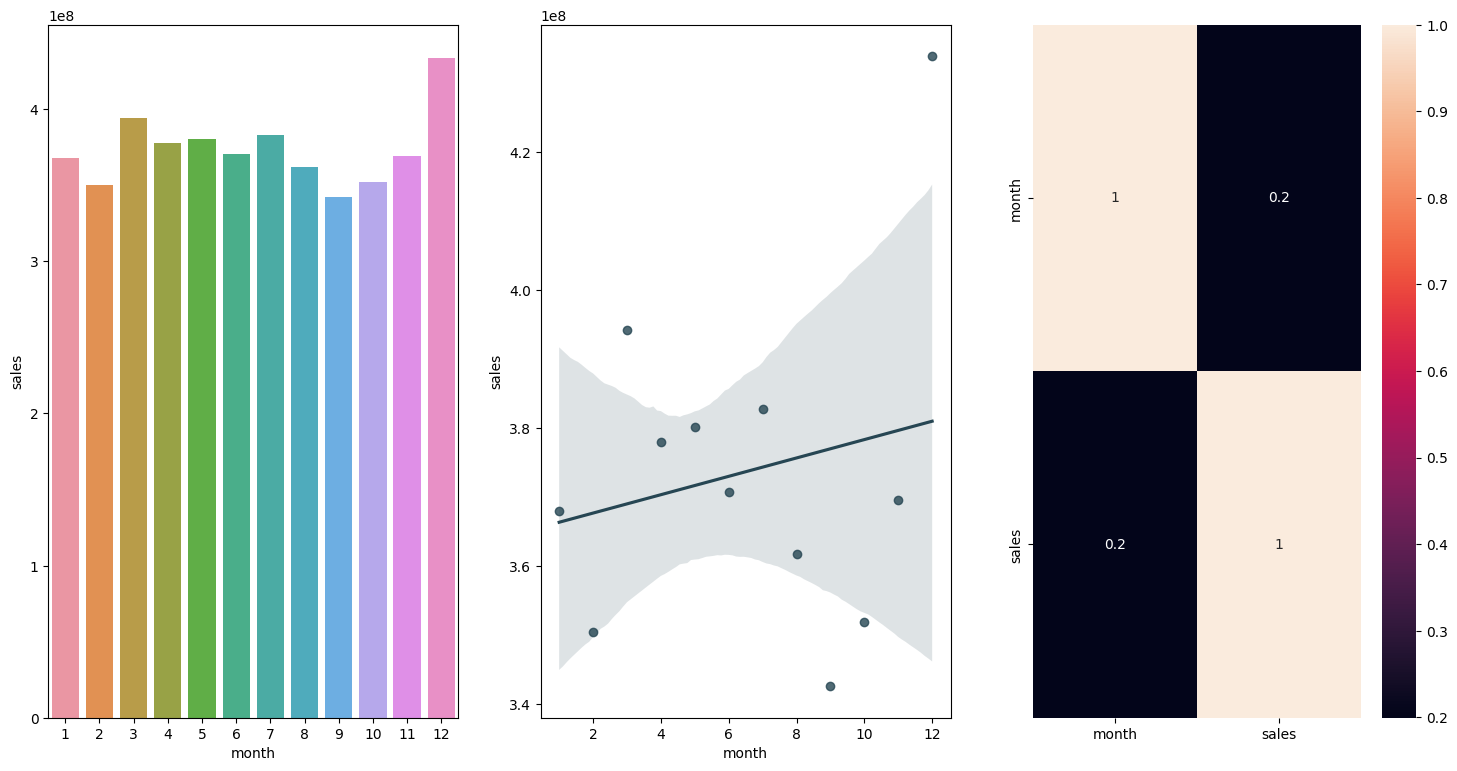

In [43]:
plt.figure(figsize= (18,9))
aux1 = df7[df7['year'] < 2015]
aux1 = aux1[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.show()

#### **H10.** Lojas deveriam vender mais na média depois do dia 10 de cada mês.
**FALSA** Lojas vendem na média menos depois do dia 10 de cada mes.

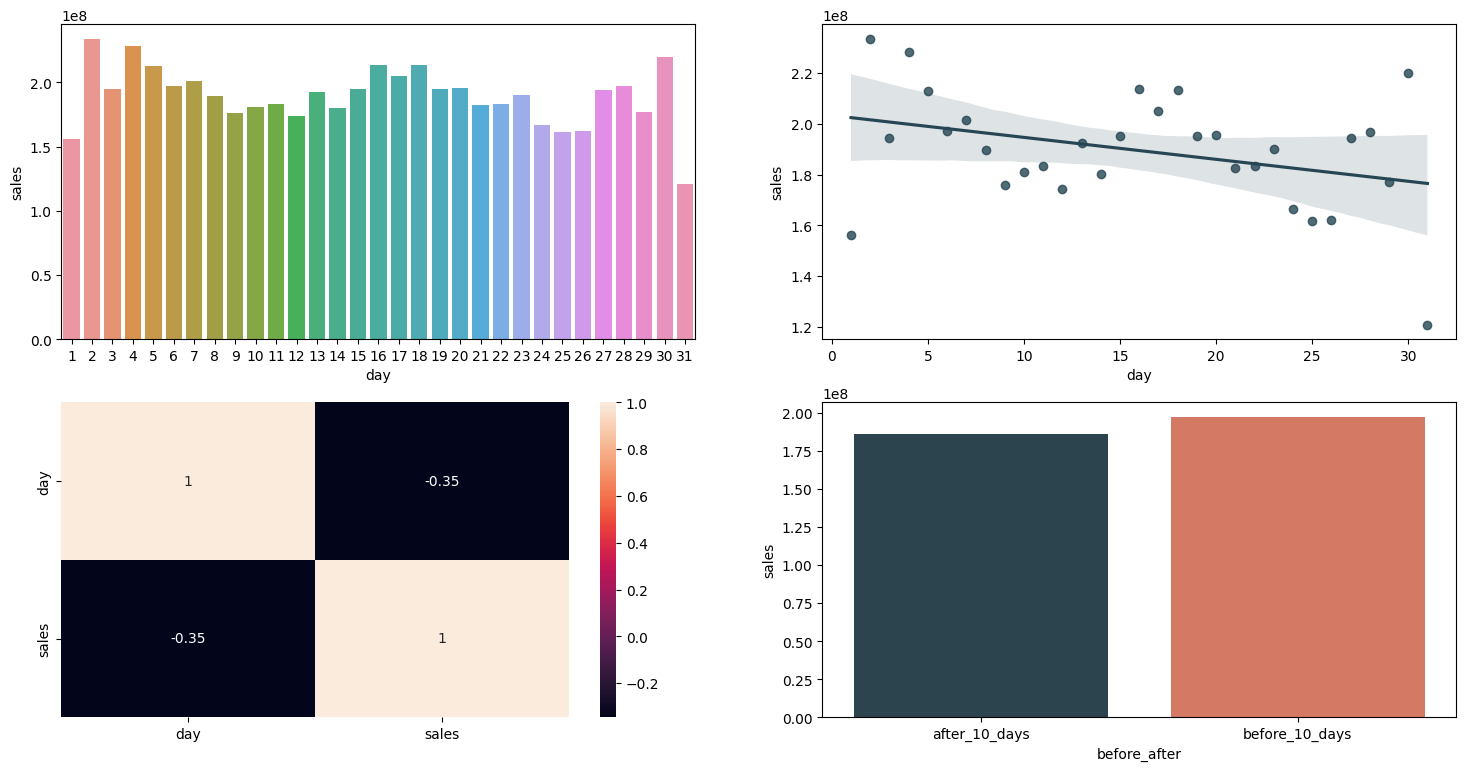

In [44]:
plt.figure(figsize= (18,9))
aux1 = df7[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 )
plt.show()

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

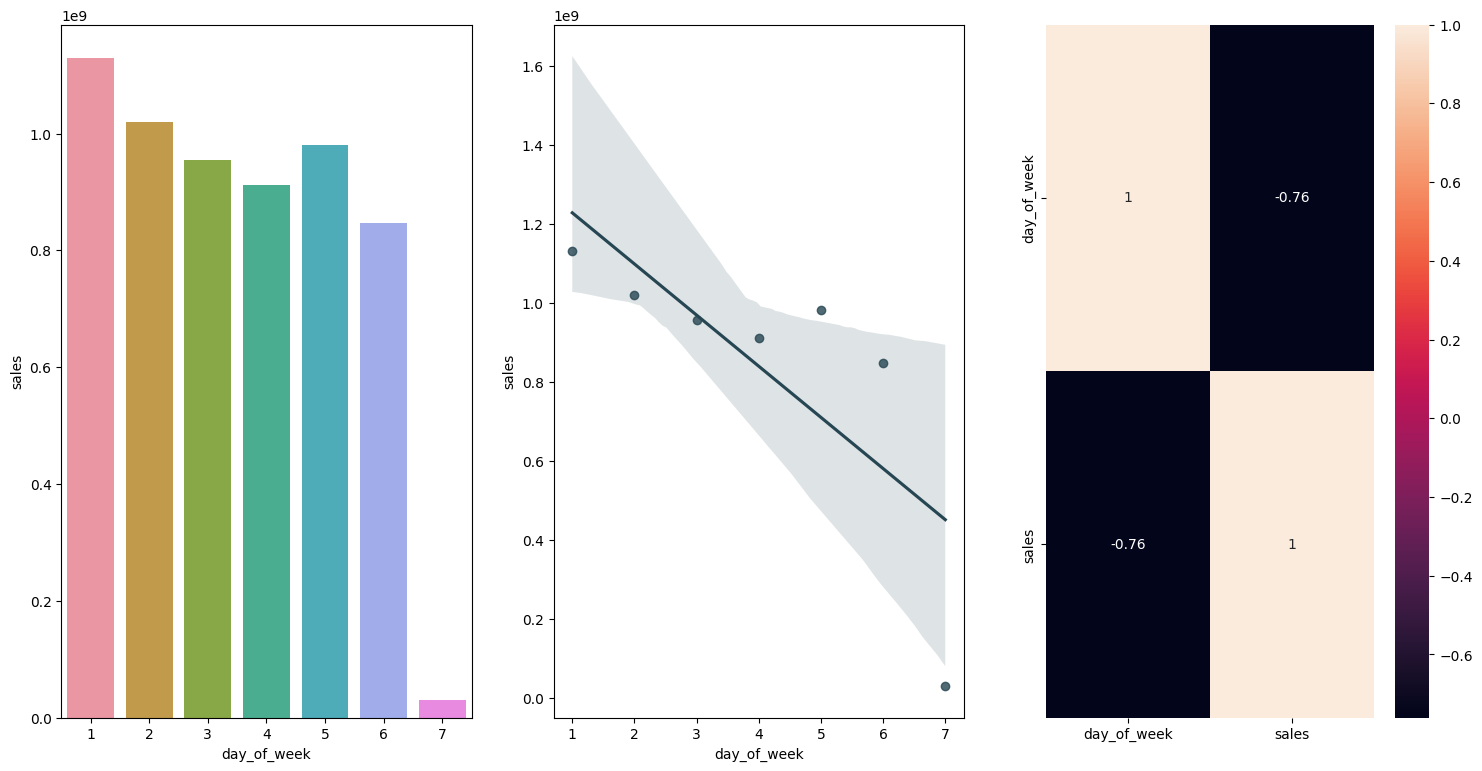

In [45]:
plt.figure(figsize= (18,9))

aux1 = df7[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.show()

#### **H12.** Lojas deveriam vender em média menos durante os feriados escolares.
**FALSA** Lojas vendem mais durante os feriadso escolares

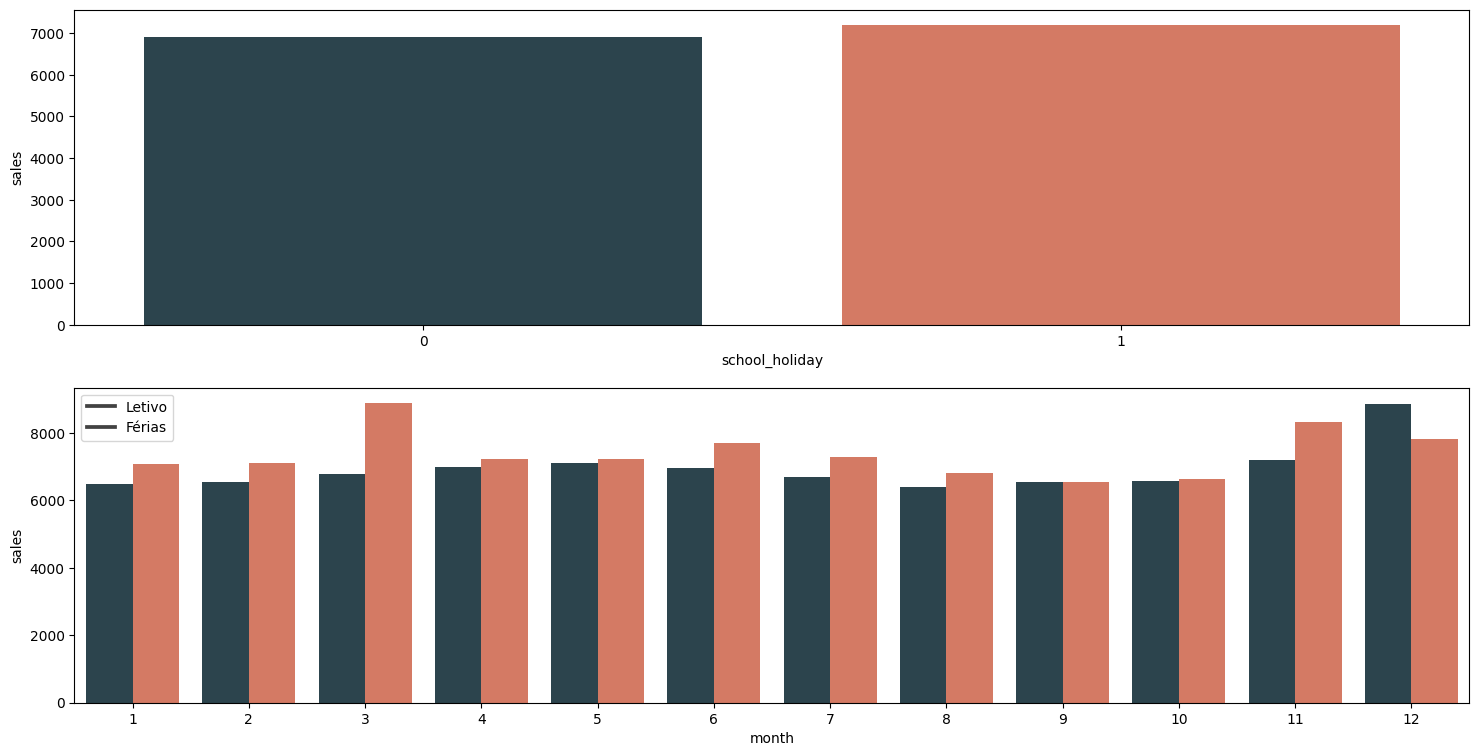

In [46]:
plt.figure(figsize= (18,9))
aux1 = df7[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 )

aux2 = df7[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )
plt.legend( labels=['Letivo', 'Férias'])
plt.show()

#### Tabela de Relevância

In [47]:
from tabulate import tabulate

#storytelling
tab_H =[['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1', 'Falsa', 'Baixa'],  
        ['H2', 'Falsa', 'Media'],  
        ['H3', 'Falsa', 'Media'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', 'Falsa', 'Media'],
        ['H6', 'Verdadeira', 'Media'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Verdadeira', 'Media'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Falsa', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12','Falsa', 'Baixa']]      
print( tabulate( tab_H, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Media
H6           Verdadeira   Media
H7           Falsa        Alta
H8           Verdadeira   Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Falsa        Baixa


### 7.3. Analise Multivariada

#### 7.3.1 Variaveis Numéricas

<Axes: >

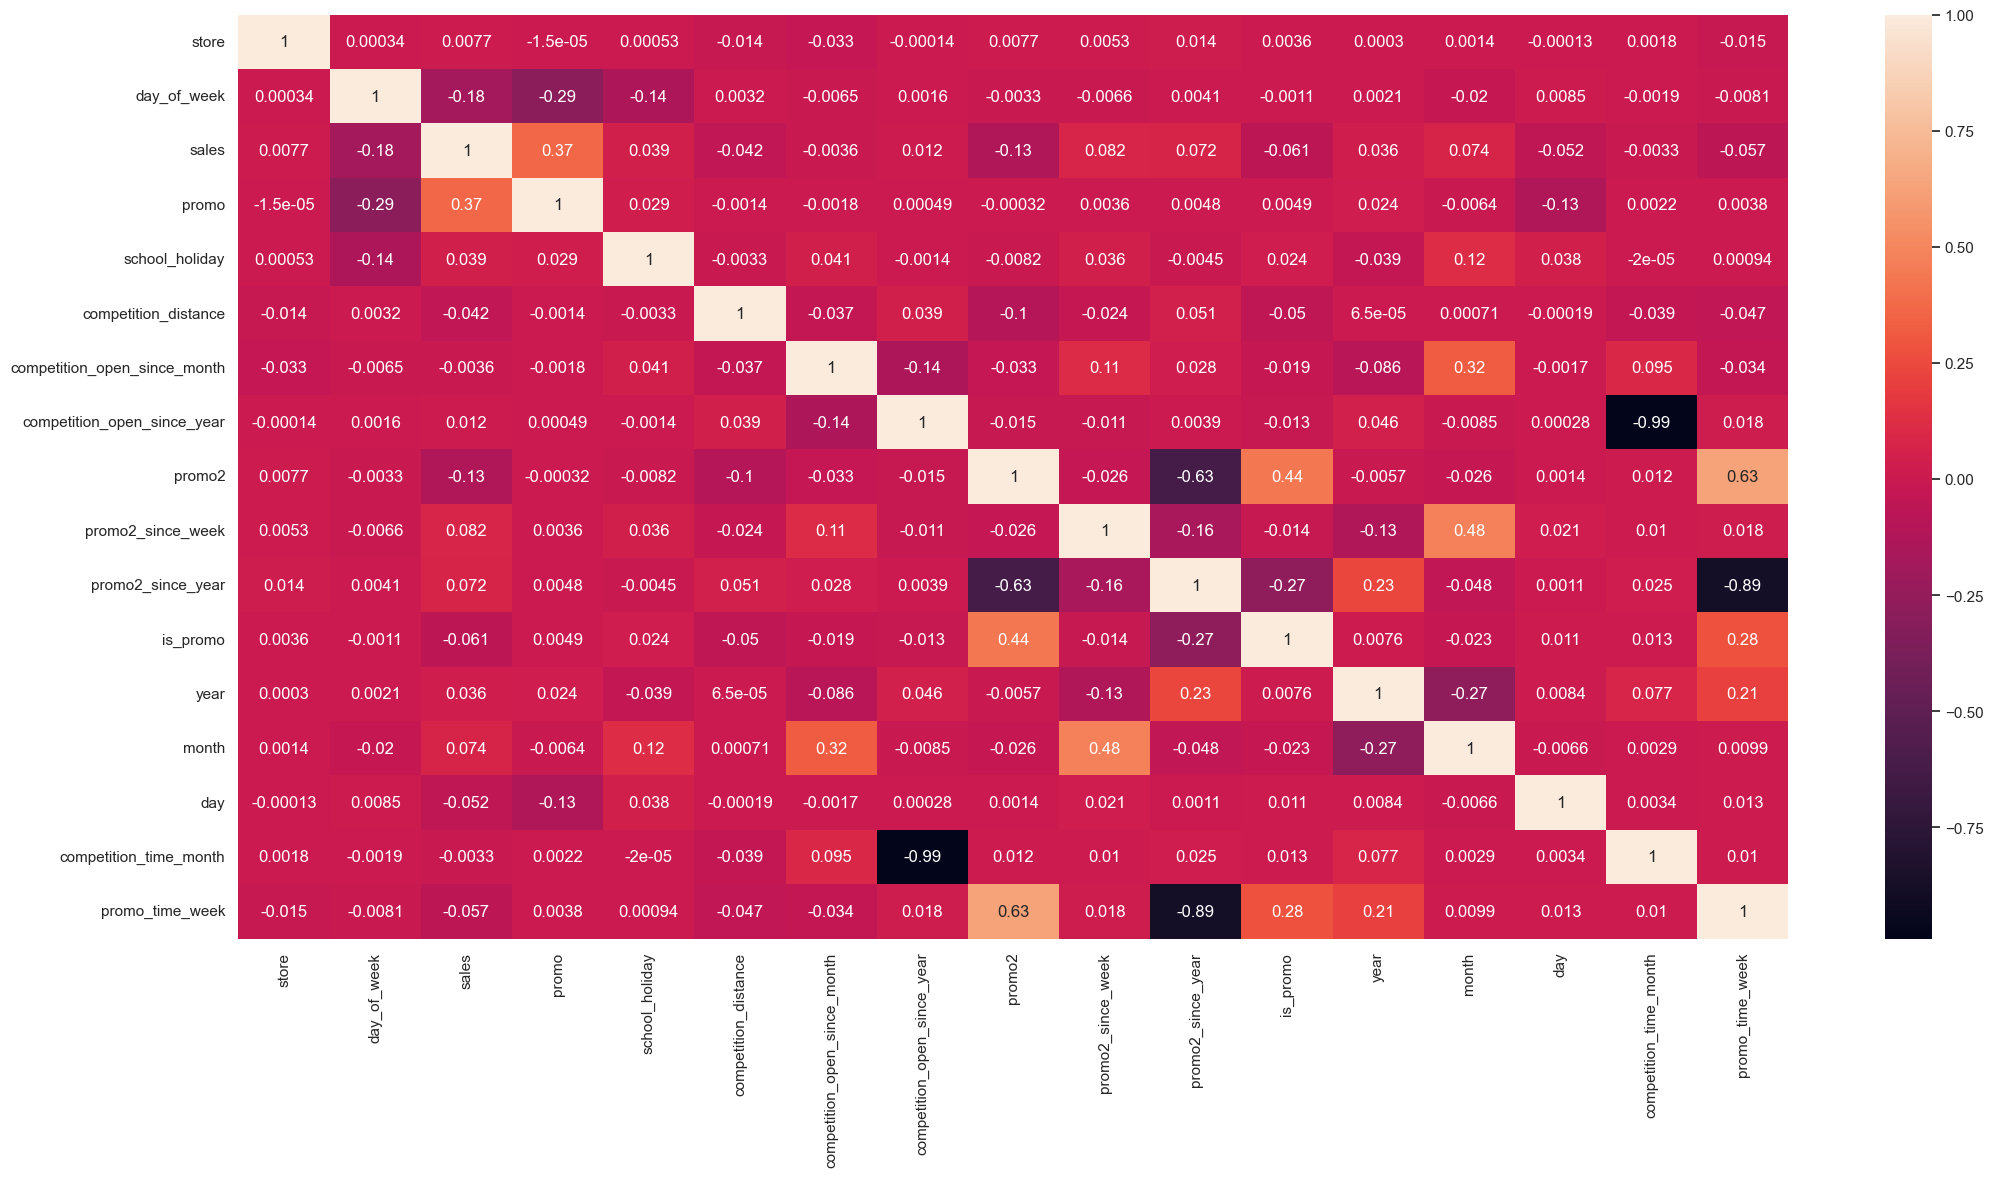

In [48]:
jupyter_settings()
num_attributes = df7.select_dtypes(include= ['int64','int32', 'float32', 'float64'])
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

#### 7.3.2 Variaveis Categóricas

<Axes: >

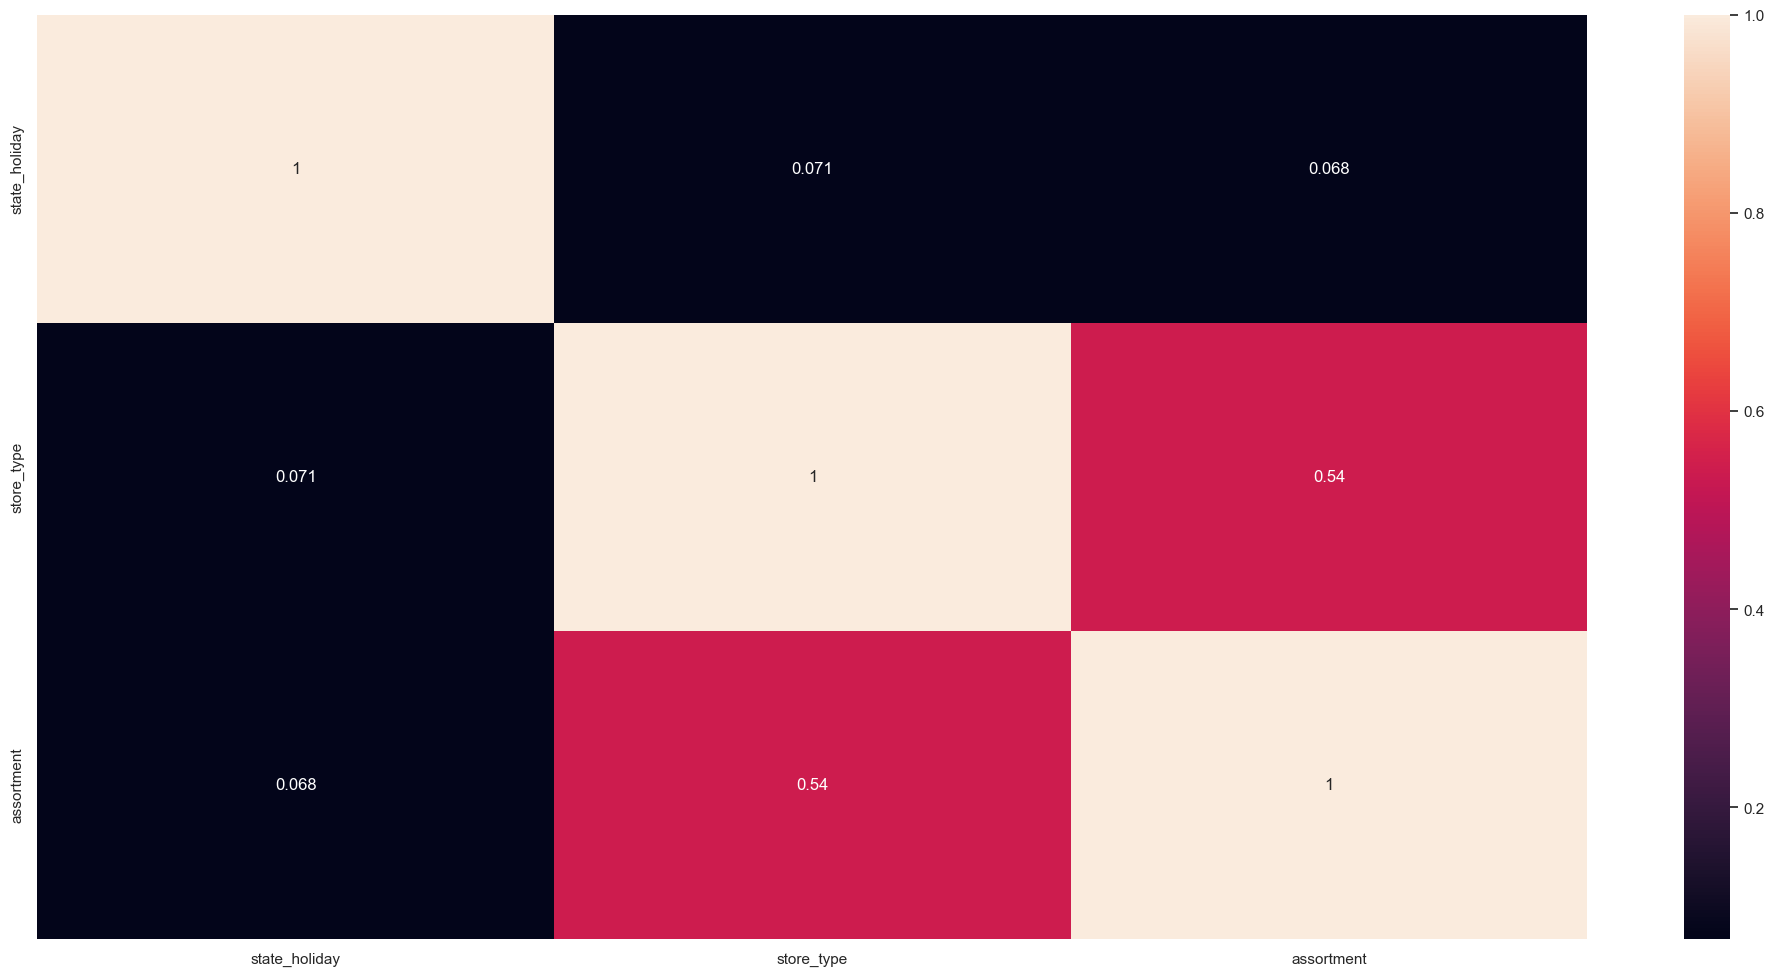

In [49]:
# only categorical data 
a = df7.select_dtypes( include='object' )
# Calculate cramer V 
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )


a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )



a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )


# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7,a8,a9]})
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 8. Data Preparation

In [48]:
df8 = df7.copy()

### 8.1 Rescaling

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df8['competition_distance'] = rs.fit_transform(df8[['competition_distance']].values)

# competition time month
df8['competition_time_month'] = rs.fit_transform( df8[['competition_time_month']].values )

# promo time week
df8['promo_time_week'] = mms.fit_transform( df8[['promo_time_week']].values )

# year
df8['year'] = mms.fit_transform( df8[['year']].values )

### 8.2 Transformation

#### 8.2.1 Encoding

In [50]:
# state_holiday - One Hot Encoding
df8 = pd.get_dummies( df8, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df8['store_type'] = le.fit_transform( df8['store_type'] )


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df8['assortment'] = df8['assortment'].map( assortment_dict )

#### 8.2.2 Response Variable Transformation

In [51]:
# Transformação Logaritmica
df8['sales'] = np.log1p(df8['sales'])

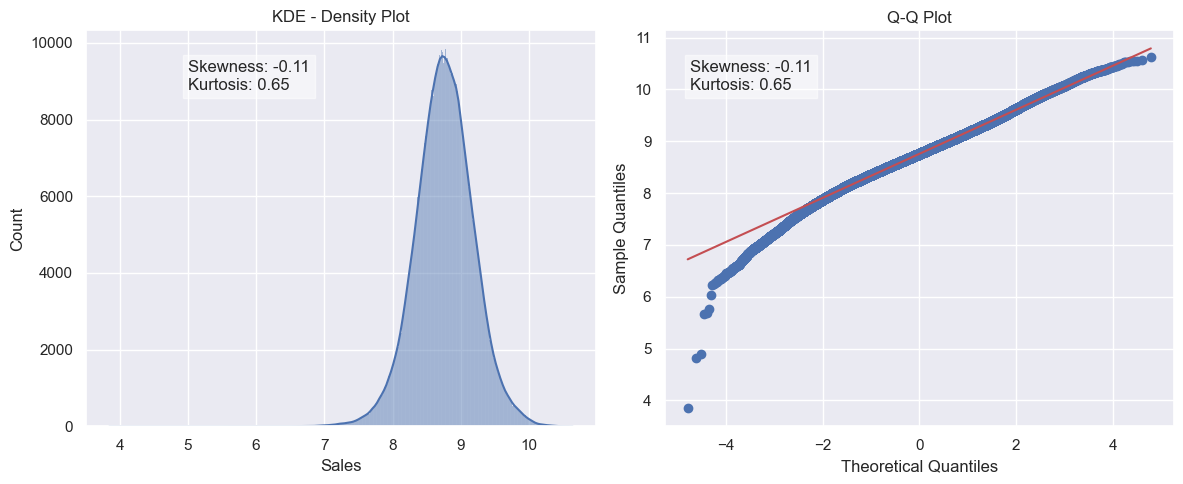

In [54]:
# Distribuição da variavel target após transformação
dist_sales(df8)

#### 8.2.3 Nature Transformation

In [52]:
# day of week
df8['day_of_week_sin'] = df8['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df8['day_of_week_cos'] = df8['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df8['month_sin'] = df8['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df8['month_cos'] = df8['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df8['day_sin'] = df8['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df8['day_cos'] = df8['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df8['week_of_year_sin'] = df8['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df8['week_of_year_cos'] = df8['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [56]:
# Descrição dos dados após alterações
summary_stats(df8, index_target= 2)

,counts,mean,std,median,sum,min,max,range,25%,75%,skew,kurt
store,844338.00,558.42,321.73,558.00,471496386.00,1.00,1115.00,1114.00,280.00,837.00,0.00,-1.20
day_of_week,844338.00,3.52,1.72,3.00,2972365.00,1.00,7.00,6.00,2.00,5.00,0.02,-1.26
sales,844338.00,8.76,0.43,8.76,7394489.96,3.85,10.63,6.78,8.49,9.03,-0.11,0.65
promo,844338.00,0.45,0.50,0.00,376875.00,0.00,1.00,1.00,0.00,1.00,0.22,-1.95
school_holiday,844338.00,0.19,0.40,0.00,163445.00,0.00,1.00,1.00,0.00,0.00,1.55,0.41
store_type,844338.00,1.21,1.36,0.00,1017800.00,0.00,3.00,3.00,0.00,3.00,0.35,-1.73
assortment,844338.00,1.94,0.99,1.00,1635055.00,1.00,3.00,2.00,1.00,3.00,0.13,-1.97
competition_distance,844338.00,0.59,2.03,0.00,494595.16,-0.37,31.88,32.25,-0.26,0.74,10.13,145.29
competition_open_since_month,844338.00,6.79,3.31,7.00,5730822.00,1.00,12.00,11.00,4.00,10.00,-0.05,-1.23
competition_open_since_year,844338.00,2010.33,5.50,2012.00,1697398942.00,1900.00,2015.00,115.00,2008.00,2014.00,-7.22,123.90


# 9. Feature Selection

In [55]:
df9 = df8.copy()

### 9.1 Split dataframe into training and test dataset

In [56]:
# Excluindo colunas 

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df9 = df9.drop( cols_drop, axis=1 )

In [57]:
# training dataset
X_train = df9[df9['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df9[df9['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 9.2. RFE as Feature Selector

In [163]:

# # Registrar o tempo antes de executar as operações
# start_time = time.time()

# # training and test dataset for RFE
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=5)

# selector = RFE(rf, step=1, verbose=1)
# selector = selector.fit(X_train_n, y_train_n)

# # Calcular o tempo gasto
# end_time = time.time()
# elapsed_time = end_time - start_time

# # Imprimir o tempo gasto
# print(f"Tempo gasto: {elapsed_time:.2f} segundos")

In [ ]:
# train = X_train.drop( ['date', 'sales'], axis=1 )
# cols_select = train.columns[selector.get_support()].to_list()
# cols_select

#Tempo gasto: 5942.56 segundos

In [ ]:
# # Ranking gerado pelo modelo

# rank_RFE = [{'Feature':col, 'Ranking': rank} for col, rank in zip(train.columns, selector.ranking_)]

# #salvar para documentação
# pd.DataFrame(rank_RFE).sort_values('Ranking').to_csv('parameter/rank_RFE')

In [42]:
cols_select_RFE = ['store', 'promo', 'store_type', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_cos']


In [61]:
# rank =  pd.DataFrame(rank_RFE).sort_values('Ranking')

# rank[rank['Ranking'] < 5]

### 9.3 Manual Feature Selection 

In [44]:
cols_select = ['store',
                'promo',
                'store_type',
                'competition_distance',
                'competition_open_since_month',
                'competition_open_since_year',
                'promo2_since_week',
                'promo2_since_year',
                'competition_time_month',
                'promo_time_week',
                'day_of_week_sin',
                'day_of_week_cos',
                'day_cos',
                'day_sin',
                'month_cos',
                'month_sin'
       ]

# 10. Machine Learning modeling

In [58]:
X_train = X_train[cols_select]
X_test = X_test[cols_select]

### 10.1 Avarage Model

In [64]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()


#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')

yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error(' Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [166]:
# Teste com a média do passado e prevendo o futuro

aux1 = X_train.copy()
aux1['sales'] = y_train.copy()
aux1
#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(X_test, aux2, how = 'left', on = 'store')

yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error(' Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.763326,0.216814,1939.32873


In [59]:
# Concaternar para o Cross Validation

y = pd.concat([y_train, y_test])
X = pd.concat([X_train, X_test])

### 10.2. Linear Regression Model

In [168]:
# model
lr = LinearRegression()

#performance
lr_result = timeSeries_CV(X, y, model_name='Linear Regression', model=lr, kfold=5)
lr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2158.6 +/- 313.1,0.31 +/- 0.02,3095.71 +/- 395.09


### 10.3. Linear Regression Regularized Model - Lasso

In [169]:
# Model
lrr = Lasso(alpha= 0.001)

#Performance
lrr_result = timeSeries_CV(X, y, model_name='Linear Regression - Lasso', model=lrr, kfold=5)
lrr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2015.91 +/- 85.56,0.32 +/- 0.01,2886.78 +/- 153.42


### 10.4. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )

# performance
rf_result = timeSeries_CV(X, y, model_name='Random Forest Regressor', model=rf, kfold=5)
rf_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1161.59 +/- 213.68,0.17 +/- 0.03,1885.56 +/- 363.55


### 10.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor()

# performance
xgb_result = timeSeries_CV(X, y, model_name= 'XGBoost Regressor', model=model_xgb, kfold=5)
xgb_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1115.1 +/- 172.14,0.17 +/- 0.02,1625.86 +/- 281.25


### 10.6 Gradient Boosting

In [ ]:
# model
model_GBDT = GradientBoostingRegressor()

#performance

model_GBDT = timeSeries_CV(X, y, model_name= 'GradienteBoost Regressor', model= model_GBDT, kfold= 5)
model_GBDT

,Model Name,MAE CV,MAPE CV,RMSE CV
0,GradienteBoost Regressor,1815.51 +/- 92.58,0.28 +/- 0.01,2610.7 +/- 129.24


### 10.6 Compare Model's Performance

In [ ]:
modelling_result = pd.concat( [lr_result, lrr_result, rf_result, xgb_result, model_GBDT] )
modelling_result.sort_values( 'RMSE CV' )


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1115.1 +/- 172.14,0.17 +/- 0.02,1625.86 +/- 281.25
0,Random Forest Regressor,1161.59 +/- 213.68,0.17 +/- 0.03,1885.56 +/- 363.55
0,GradienteBoost Regressor,1815.51 +/- 92.58,0.28 +/- 0.01,2610.7 +/- 129.24
0,Linear Regression - Lasso,2015.91 +/- 85.56,0.32 +/- 0.01,2886.78 +/- 153.42
0,Linear Regression,2158.6 +/- 313.1,0.31 +/- 0.02,3095.71 +/- 395.09


# 11. Hyperparameter Tuning

### 11.1. Encontrando o Subespaço Vetorial para Fine-Tuning, Utilizando o BayesianSearchCV

Estou planejando otimizar meu modelo usando o método de fine-tuning conhecido como BayesianSearchCV. Para tornar o processo mais eficiente, pretendo trabalhar com uma amostra dos dados de treinamento, que consistem em séries temporais. Isso me permitirá realizar mais iterações para explorar diversas combinações de hiperparâmetros e obter insights sobre como eles afetam o desempenho do modelo.

Usando gráficos, como o de coordenadas paralelas (Parallel Coordinate Plot), vou visualizar a relação entre diferentes hiperparâmetros e métricas de avaliação, como o MSE (Mean Squared Error). Isso me ajudará a identificar os ajustes mais promissores para melhorar o desempenho do modelo.

Com base nas observações desses gráficos, selecionarei os hiperparâmetros mais relevantes e os usarei em um GridSearch com intervalo reduzido pelo estudo feito com o BayseansSearchCV, aplicado ao conjunto completo de dados de treinamento. O foco será nos hiperparâmetros que mais impactaram positivamente o MSE.

Essa abordagem me permitirá otimizar meu modelo de previsão de séries temporais de forma eficiente, aprendendo com os resultados obtidos em cada etapa do processo.


#### 11.1.1 Determinando o Tamanho da Amostra

Para finalizar a criação da amostra, optarei por selecionar as instâncias correspondentes ao último ano presente no conjunto de dados de treinamento.

In [60]:
amostra = df8.copy()
# Excluindo colunas 

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
amostra = amostra.drop( cols_drop, axis=1 )

# training dataset
X_amostra = amostra[amostra['date'] > '2014-07-31']
y_amostra = X_amostra['sales']

#Features selecionadas

X_amostra = X_amostra[cols_select]

print(f'Tamanho da amostra {len(X_amostra)}, o que representa {(len(X_amostra)/len(X))*100:.2f}%')


Tamanho da amostra 315540, o que representa 37.37%


#### 11.1.2 Hyperparameter Tuning com BayesianSearchCV

In [186]:
# Registrar o tempo antes de executar as operações
start_time = time.time()

#model

xgb_bay = xgb.XGBRegressor()

# Bayesian
n_iter = 50

# Criar objeto TimeSeriesSplit para validação cruzada
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {'max_depth': [9,10, 11, 12], 
            'learning_rate': [0.05, 0.1, 0.15], 
            'subsample': [0.6,0.8,0.9],
            'n_estimators': [600,800,100]}


reg_bay =  BayesSearchCV(estimator= xgb_bay,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=tscv,
                    n_jobs=8,
                    scoring= 'neg_root_mean_squared_error',
                    return_train_score = True,
                    random_state=123, verbose= 5 )

model_bay = reg_bay.fit(X_amostra, y_amostra)

# Calcular o tempo gasto
end_time = time.time()
elapsed_time = end_time - start_time

# Imprimir o tempo gasto
print(f"Tempo gasto: {elapsed_time:.2f} segundos")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [61]:
# Salvar o estudo para documentação

#pickle.dump(model_bay, file =  open('C:/Users/55329/Documents/3.Repos/Rossmann-sales/model/model_bay.pkl', 'wb'))

# Abrir arquivo 

model_bay = pickle.load(open('model/model_bay.pkl', 'rb'))

#### 11.1.3 Eliminando parâmetros

In [62]:
# Criando um dataframe com os resultados obtidos na iteração
cv_results = pd.DataFrame(model_bay.cv_results_)

# convertendo para valores positivos 
cv_results[['mean_test_score', 'mean_train_score']] = abs(cv_results[['mean_test_score', 'mean_train_score']])

# Converter para float

cols = ['param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_subsample','rank_test_score','mean_test_score']

cv_results[cols] = cv_results[cols].astype(float)

cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,rank_train_score
0,48.124901,18.739072,0.551032,0.103231,0.15,10.0,100.0,0.8,"{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",-0.226949,-0.274928,-0.185520,0.229132,0.036533,41.0,-0.095198,-0.105995,-0.110408,0.103867,0.006389,45
1,465.376104,183.825084,5.969096,0.369289,0.15,11.0,800.0,0.6,"{'learning_rate': 0.15, 'max_depth': 11, 'n_es...",-0.233017,-0.288397,-0.174477,0.231963,0.046514,45.0,-0.009841,-0.021630,-0.029046,0.020172,0.007908,7
2,55.828722,20.196672,0.516546,0.094713,0.10,11.0,100.0,0.6,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",-0.224907,-0.279997,-0.192972,0.232625,0.035945,47.0,-0.105230,-0.119004,-0.127920,0.117385,0.009334,47


##### 11.1.3.1 Parallel Coordinates

No gráfico a seguir, fica evidente que ao escolher os 10 melhores modelos, é possível identificar a eliminação de alguns parâmetros, como n_estimators = 100, learning_rate = 0.15 e max_depth = 9.


In [230]:
import plotly.express as px
cols = ['param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_subsample','rank_test_score','mean_test_score']


labels = {'param_learning_rate': 'learning_rate', 
            'param_max_depth': 'max_depth',
            'param_n_estimators': 'n_estimators',
            'param_subsample': 'subsample',
            'rank_test_score': 'rank',
            'mean_test_score': 'mean score'}

cv_result = cv_results[cols].astype(float)


fig = px.parallel_coordinates(cv_result, color="mean_test_score",
                              labels = labels,
                                color_continuous_scale=px.colors.diverging.Portland
                                          )



fig.show()

fig.write_html('parallel_coodinate_pop.html')

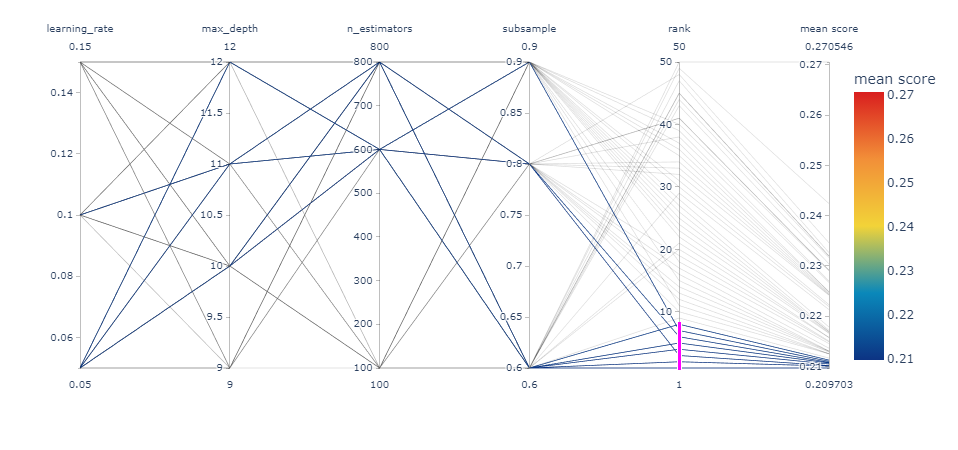

In [2]:
# Filtrado apenas os 10 melhores

from IPython.display import Image
Image('img/parallel_cordinate.png')

##### 11.1.3.1 Gráfico de dispersão

* **lerning_rate** :Analisando os gráficos abaixo, é perceptível que a dispersão é menor para o valor de 0.05 em learning_rate, apresentando uma correlação positiva. Optarei por escolher exclusivamente o valor de 0.05. Ao selecionar apenas esse valor no gráfico de coordenadas paralelas, ainda manteremos a maioria dos valores que figuram entre os 10 melhores.
*  **Subsample**: Ao analisar o subsample, é evidente uma correlação negativa com nossa métrica. Embora nenhum dos valores tenha sido eliminado no gráfico de coordenadas paralelas, optei por remover o valor de 0.60 devido à sua maior dispersão em relação aos demais valores.

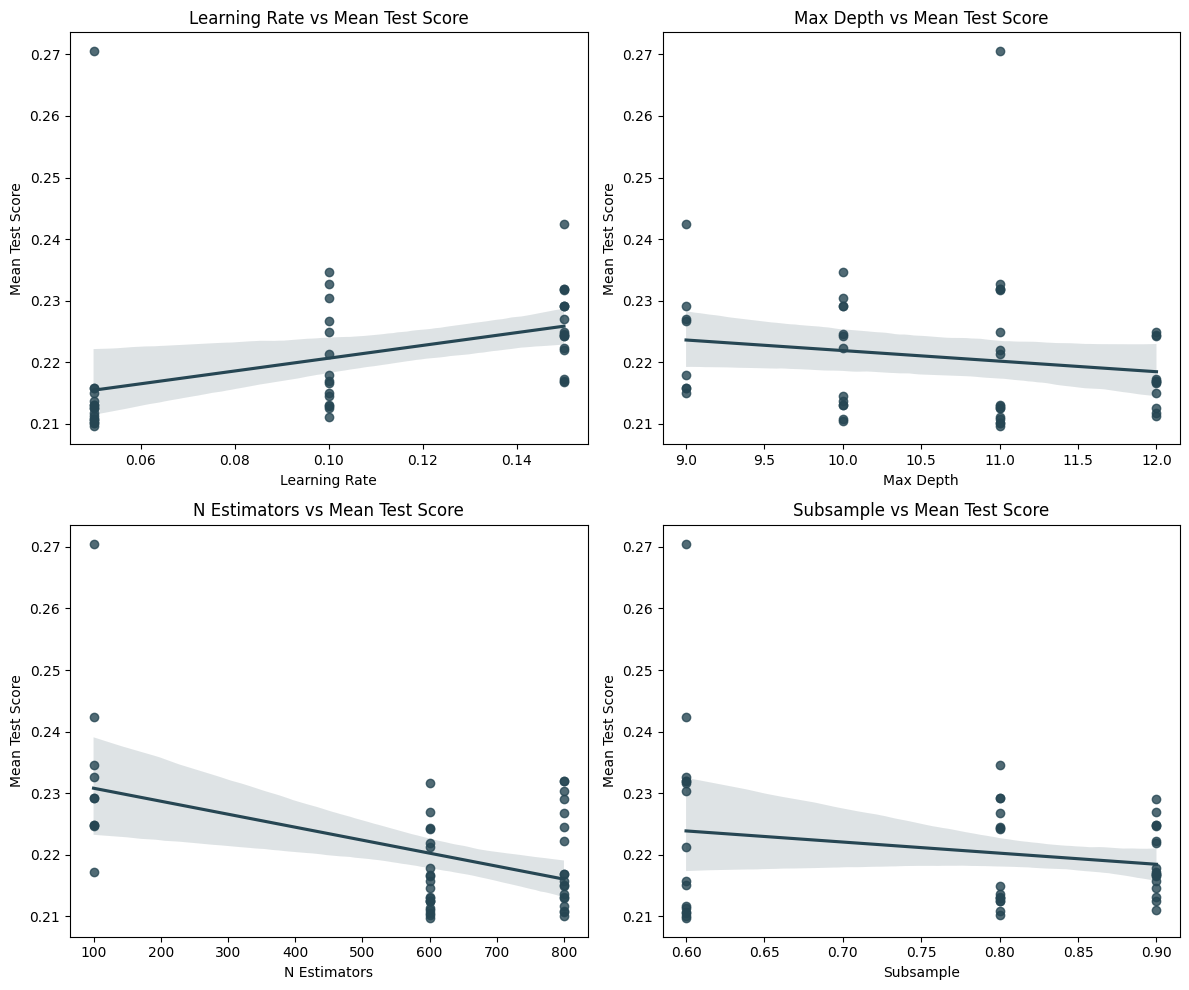

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cria uma figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Traçar o gráfico de dispersão com a linha de regressão - Learning Rate
sns.regplot(x=cv_results['param_learning_rate'], y=cv_results['mean_test_score'], ax=axes[0, 0])
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Mean Test Score')
axes[0, 0].set_title('Learning Rate vs Mean Test Score')

# Traçar o gráfico de dispersão com a linha de regressão - Max Depth
sns.regplot(x=cv_results['param_max_depth'], y=cv_results['mean_test_score'], ax=axes[0, 1])
axes[0, 1].set_xlabel('Max Depth')
axes[0, 1].set_ylabel('Mean Test Score')
axes[0, 1].set_title('Max Depth vs Mean Test Score')

# Traçar o gráfico de dispersão com a linha de regressão - N Estimators
sns.regplot(x=cv_results['param_n_estimators'], y=cv_results['mean_test_score'], ax=axes[1, 0])
axes[1, 0].set_xlabel('N Estimators')
axes[1, 0].set_ylabel('Mean Test Score')
axes[1, 0].set_title('N Estimators vs Mean Test Score')

# Traçar o gráfico de dispersão com a linha de regressão - Subsample
sns.regplot(x=cv_results['param_subsample'], y=cv_results['mean_test_score'], ax=axes[1, 1])
axes[1, 1].set_xlabel('Subsample')
axes[1, 1].set_ylabel('Mean Test Score')
axes[1, 1].set_title('Subsample vs Mean Test Score')

plt.tight_layout()
plt.show()


#### 11.1.4 Parâmetros

In [254]:
param_grid = {'max_depth': [11, 12], 
            'learning_rate': [0.05], 
            'subsample': [0.8,0.9],
            'n_estimators': [600,800]}

In [260]:
model_xgb_bay = timeSeries_CV(X, y, model_name= 'GradienteBoost Regressor', model= model_bay.best_estimator_, kfold= 5)
model_xgb_bay

,Model Name,MAE CV,MAPE CV,RMSE CV
0,GradienteBoost Regressor,944.62 +/- 186.42,0.14 +/- 0.02,1433.13 +/- 313.39


### 11.2. Hyperparameter Tuning com GridSearchCV

In [256]:
# Registrar o tempo antes de executar as operações
start_time = time.time()

# Model
xgb_grid = xgb.XGBRegressor()

# Criar objeto TimeSeriesSplit para validação cruzada
tscv = TimeSeriesSplit(n_splits=5)

reg_grid = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=8,
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    verbose=5
)

model_grid = reg_grid.fit(X, y)

# Calcular o tempo gasto
end_time = time.time()
elapsed_time = end_time - start_time

# Imprimir o tempo gasto
print(f"Tempo gasto: {elapsed_time:.2f} segundos")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tempo gasto: 14043.83 segundos


In [264]:
model_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 800, 'subsample': 0.8}

In [65]:
best_params = {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 800, 'subsample': 0.8}

In [262]:
# Salvar o estudo para documentação

pickle.dump(model_grid, file =  open('C:/Users/55329/Documents/3.Repos/Rossmann-sales/model/search_GRID.pkl', 'wb'))


### 11.3. Modelo Final

In [261]:
model_xgb_grid = timeSeries_CV(X, y, model_name= 'GradienteBoost Regressor', model= model_grid.best_estimator_, kfold= 5)
model_xgb_grid

,Model Name,MAE CV,MAPE CV,RMSE CV
0,GradienteBoost Regressor,936.38 +/- 181.95,0.14 +/- 0.02,1422.35 +/- 304.1


Houve uma melhoria de 12 pp para a métrica RMSE em relação ao modelo XGB antes do Hyperparameter Tuning

In [263]:
# Salvar o modelo

pickle.dump(model_xgb_grid, file =  open('C:/Users/55329/Documents/3.Repos/Rossmann-sales/model/model_xgb_tuned.pkl', 'wb'))

# 12. Performance

In [66]:
model_XGB_Tuned = xgb.XGBRegressor(learning_rate = best_params['learning_rate'],
                                    max_depth = best_params['max_depth'],
                                    n_estimators = best_params['n_estimators'],
                                    subsample = best_params['subsample']
                                                        ).fit(X_train[cols_select], y_train)

In [269]:
# prediction 
yhat_xgb_tuned = model_XGB_Tuned.predict(X_test[cols_select])

#performance FINAL

xgb_tuned_result = ml_error('XGBRegressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor Tuned,652.20369,0.094689,949.807688


In [284]:
df12 = df9[df9['date'] >= '2015-06-19'].copy()

#Rescale

df12['sales'] = np.expm1(y_test)
df12['predictions'] = np.expm1(yhat_xgb_tuned)

### 12.1 Bussines Performance

In [285]:
# sum of predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error         

df121 = df12[['store', 'predictions']].groupby( 'store' ).agg(['sum','mean']).reset_index()
df121.columns = df121.columns.get_level_values(1)
df121.rename(columns={'':'store','sum' : 'total_prediction','mean': 'mean_prediction'},inplace= True)

#MAE and MAPE
df12_aux1 = df12[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAE'})
df12_aux2 = df12[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'})

#merge

df12_aux3 = pd.merge( df12_aux1, df12_aux2, how='inner', on='store' )
df122 = pd.merge( df121, df12_aux3, how='inner', on='store' )



# Scenarios

df122['worst_scenario_total'] = df122['total_prediction'] - df122['MAE']*42
df122['best_scenario_total'] = df122['total_prediction'] + df122['MAE']*42

df122['worst_scenario_mean'] = df122['mean_prediction'] - df122['MAE']
df122['best_scenario_mean'] = df122['mean_prediction'] + df122['MAE']

df122['absolute_error'] = df122['MAE']*42
#order columns

# Visão total
df123 = df122[['store', 'total_prediction', 'worst_scenario_total', 'best_scenario_total', 'absolute_error' ,'MAPE']]

#visão diaria

df124 = df122[['store','mean_prediction', 'worst_scenario_mean', 'best_scenario_mean','MAE', 'MAPE']]


#### 12.1.1 Erro percentual medio de cada loja

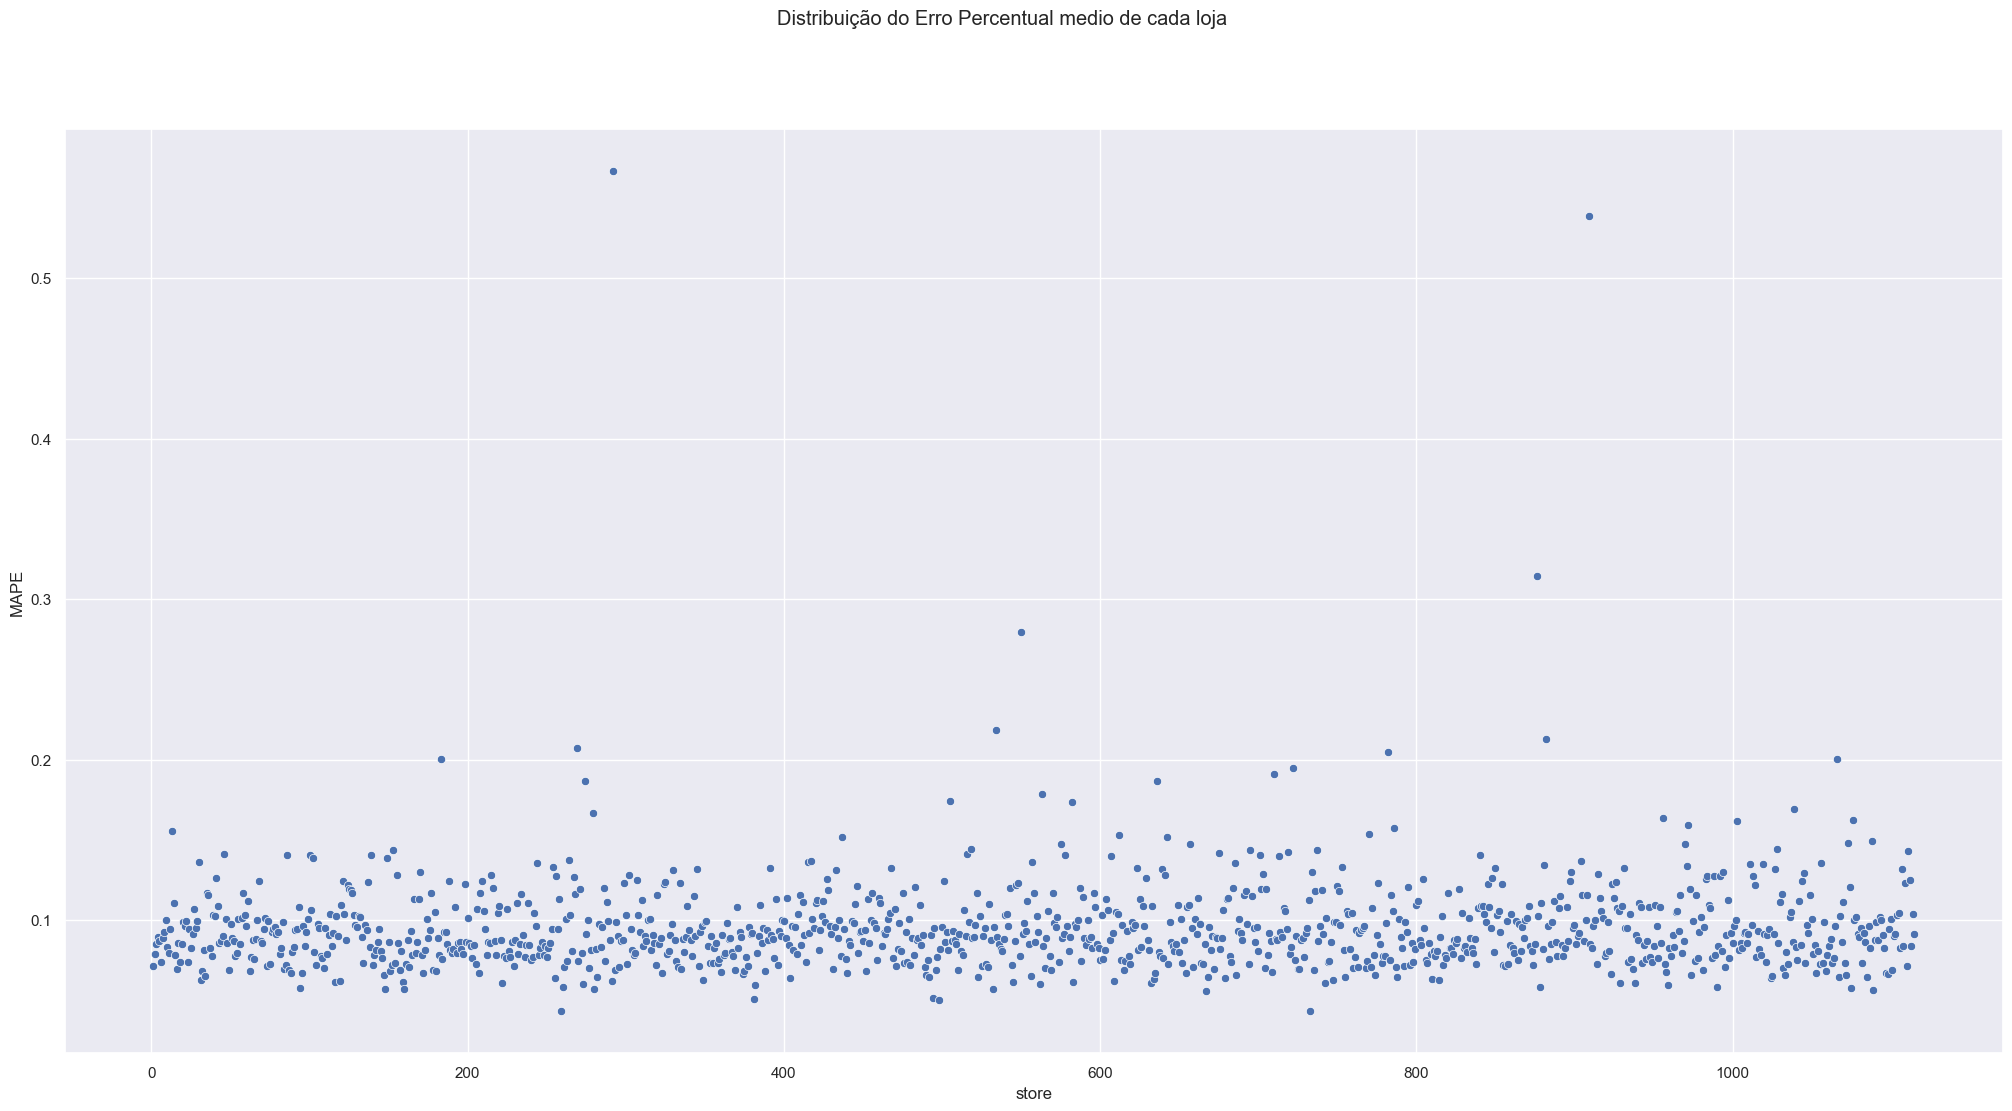

In [286]:
# Erro percentual medio de cada loja

fig = plt.figure()
fig.suptitle('Distribuição do Erro Percentual medio de cada loja')
ax = sns.scatterplot( x='store', y='MAPE', data=df122)
plt.show()

#### 12.1.2 Distribuição e Analise de Outiler no erro do modelo

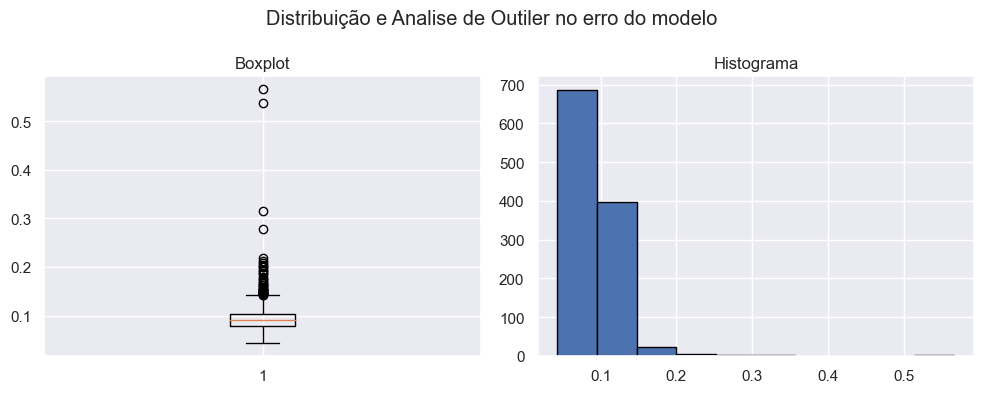

In [287]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#Titulo
fig.suptitle('Distribuição e Analise de Outiler no erro do modelo')

# Boxplot
axes[0].boxplot(df122['MAPE'])
axes[0].set_title('Boxplot')
# Histograma
axes[1].hist(df122['MAPE'], bins=10, edgecolor='black')
axes[1].set_title('Histograma')

plt.tight_layout()
plt.show()

### 12.2 Total Performance

In [288]:
df125 = df122[['total_prediction', 'worst_scenario_total', 'best_scenario_total']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df125['Values'] = df125['Values'].map( 'R${:,.2f}'.format )
df125

,Scenario,Values
0,total_prediction,"R$285,929,792.00"
1,worst_scenario_total,"R$255,210,544.58"
2,best_scenario_total,"R$316,648,977.03"


### 12.3 Machine Learning Performance

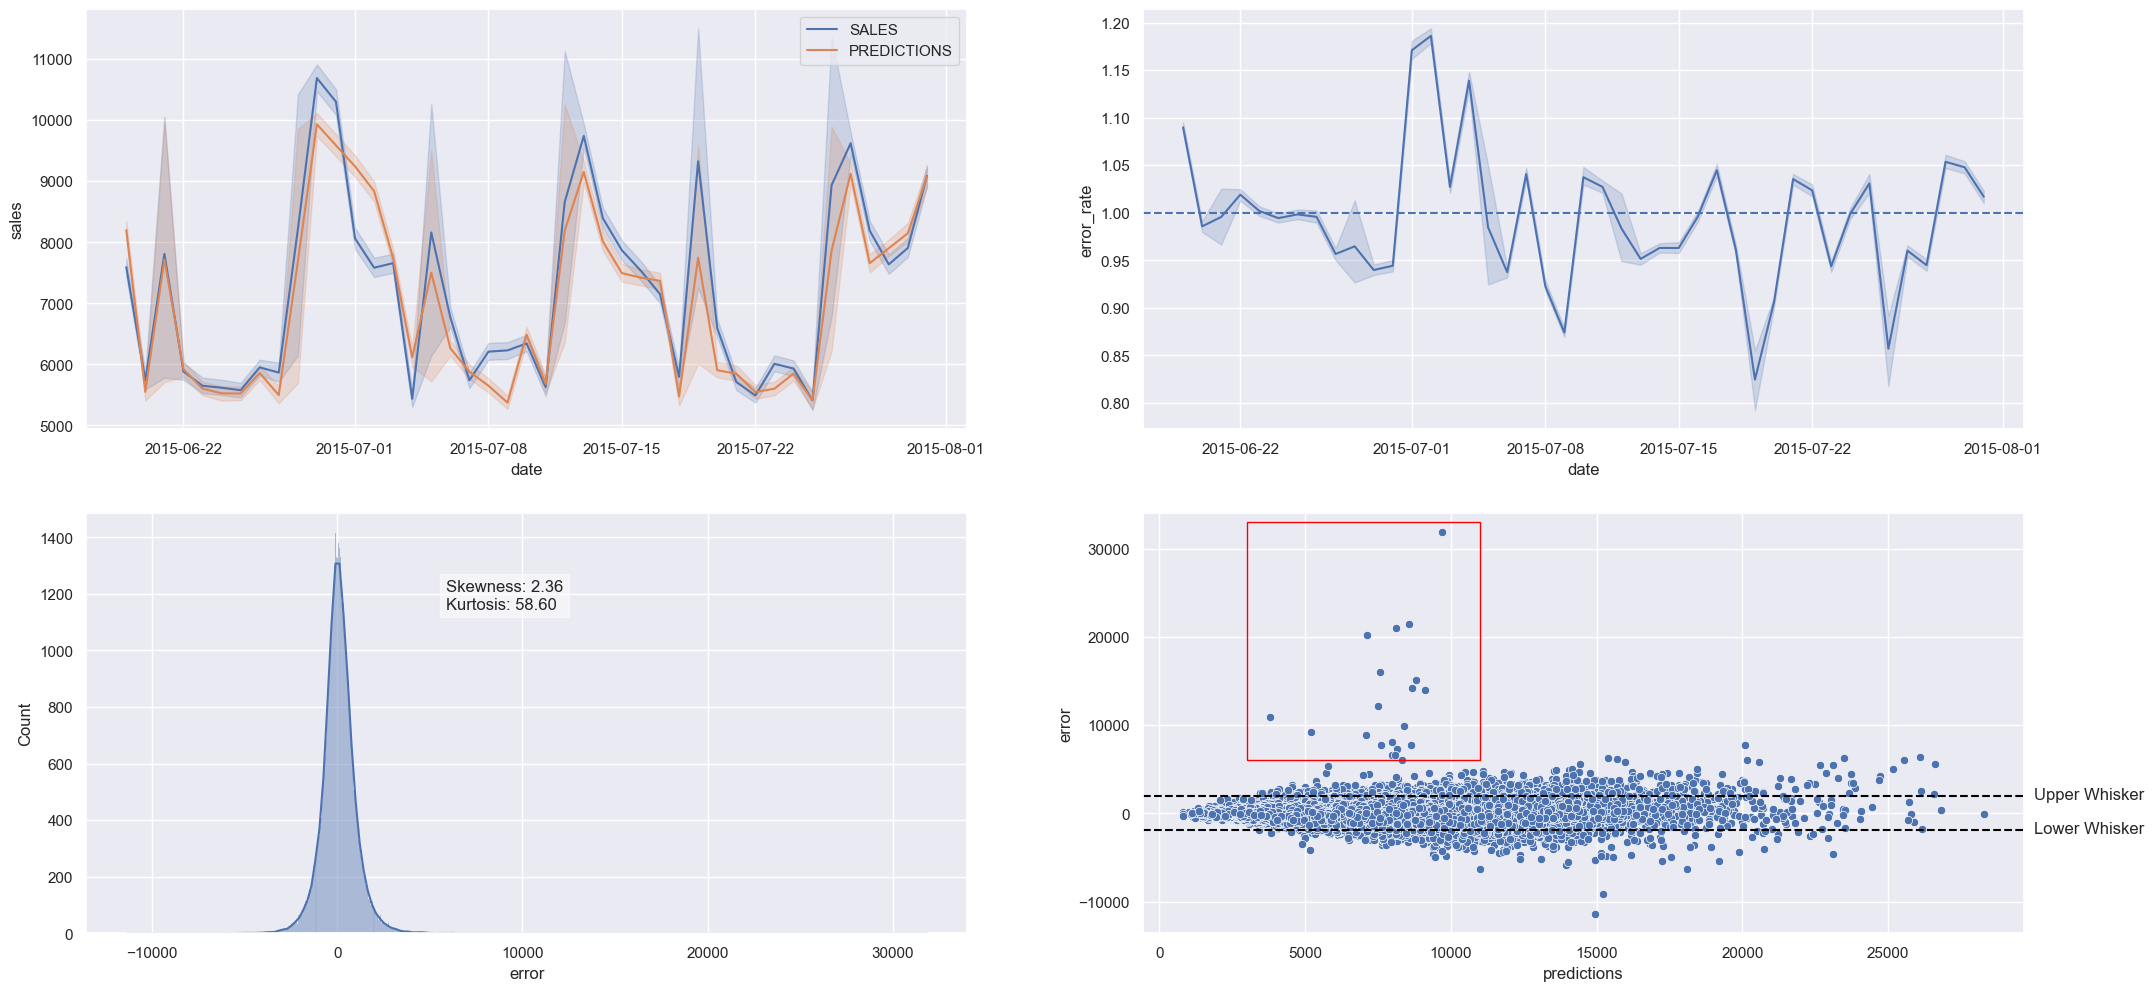

In [335]:


df12['error'] = df12['sales'] - df12['predictions']
df12['error_rate'] = df12['predictions'] / df12['sales']

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df12, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df12, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df12 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
# Cálculo da skewness e kurtosis
skewness = stats.skew(df12['error'])
kurtosis = stats.kurtosis(df12['error'])

# Texto para exibir as informações de skewness e kurtosis
info_text = f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"

plt.text(0.7, 0.85, info_text, transform=axes[0].transAxes,
bbox=dict(facecolor='white', alpha=0.5))
sns.histplot( df12['error'], kde=True)



plt.subplot( 2, 2, 4 )
sns.scatterplot(x =  df12['predictions'], y = df12['error'] )

# Calcular os quartis
q1 = df12['error'].quantile(0.25)
q3 = df12['error'].quantile(0.75)

# Calcular a amplitude interquartil (IQR)
iqr = q3 - q1

# Calcular os limites dos bigodes
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr

# Adicionar as linhas dos limites dos bigodes
plt.axhline(upper_whisker, linestyle='--', color='black', label='Upper Whisker')
plt.axhline(lower_whisker, linestyle='--', color='black', label='Lower Whisker')
plt.annotate('Upper Whisker', xy=(3000, lower_whisker), xytext=(30000, upper_whisker - 400))
plt.annotate('Lower Whisker', xy=(3000, lower_whisker), xytext=(30000, lower_whisker - 400))

# Coordenadas do retângulo
x_rect = 11000
y_rect = 6000
width = 27000
height = 8000
angle = 90  # ângulo de rotação em graus

# Criar o retângulo inclinado
rectangle = patches.Rectangle((x_rect, y_rect), width, height, angle=angle, edgecolor='red', facecolor='none')

# Adicionar o retângulo ao gráfico
plt.gca().add_patch(rectangle)




# 13. Deploy

### 13.1 Rossmann Class

In [68]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import pickle



class Rossmann(object):
    
    def __init__(self):
        
        self.home_path = '/Users/55329/Documents/3.Repos/Rossmann-sales/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time month_scaler.pkl', 'rb'))
        self.promo_time_month_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoder = pickle.load(open(self.home_path + 'parameter/store_type_encoder.pkl', 'rb'))
        
        
    def data_cleaning(self, df):
        
        ## 1.1 RENAME COLUMNS
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
                    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                    'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        #rename

        df.columns = cols_new

        ## 1.5 Fillout NA
        #competition_distance
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month    
        df['competition_open_since_month'] = df[['competition_open_since_month' , 'date']].apply( lambda x: x['date'].month 
                                                        if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'],
                                                        axis=1 )

        #competition_open_since_year     
        df['competition_open_since_year'] = df[['competition_open_since_year' , 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)                       

        #promo2_since_week              
        df['promo2_since_week'] = df[['promo2_since_week' , 'date']].apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year               
        df['promo2_since_year'] = df[['promo2_since_year' , 'date']].apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x ['promo2_since_year'], axis= 1)

        #promo_interval 
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df['promo_interval'].fillna(0, inplace= True)
        df['month_map'] = df['date'].dt.month.map(month_map)
        df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1) 
        ## 1.6 Change Data Types
        # competiton
        df['competition_open_since_month'] = df['competition_open_since_month'].astype( int )
        df['competition_open_since_year'] = df['competition_open_since_year'].astype( int )
            
        # promo2
        df['promo2_since_week'] = df['promo2_since_week'].astype( int )
        df['promo2_since_year'] = df['promo2_since_year'].astype( int )
        
        return df
        
    def feature_engineering(self, df):
        
        ### 2.4. Feature Engineering
        # year
        df['year'] = df['date'].dt.year

        # month
        df['month'] = df['date'].dt.month

        # day
        df['day'] = df['date'].dt.day

        # week of year
        df['week_of_year'] = df['date'].dt.isocalendar().week

        # year week
        df['year_week'] = df['date'].dt.strftime( '%Y-%W' )

        # competition since
        df['competition_since'] = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df['competition_time_month'] = ( ( df['date'] - df['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df['promo_since'] = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
        df['promo_since'] = df['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df['promo_time_week'] = ( ( df['date'] - df['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        ## 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ### 3.1. Filtragem das Linhas
        # Quero apenas dados onde a loja esta aberta e que valor de vendas seja maior que 0

        ### 3.2. Selecao das Colunas
        
        # Excluir colunas na qual eu não terei durante o processo de previsão
        cols_drop = ['open', 'promo_interval', 'month_map']
        df = df.drop( cols_drop, axis=1 )
        return df
    
    def data_preparation(self, df):
        
        ## 5.1 Rescaling

        # competition distance
        df['competition_distance'] = self.competition_distance_scaler.fit_transform(df[['competition_distance']].values)

        # competition time month
        df['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df[['competition_time_month']].values )

        # promo time week
        df['promo_time_week'] = self.promo_time_month_scaler.fit_transform( df[['promo_time_week']].values )

        # year
        df['year'] = self.year_scaler.fit_transform( df[['year']].values )

        ## 5.2 Transformacao
        ### 5.2.1 Encoding
        
        # state_holiday - One Hot Encoding
        df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        
        df['store_type'] = self.store_type_encoder.fit_transform( df['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df['assortment'] = df['assortment'].map( assortment_dict )
        
        ### 5.2.2 Response Variable Transformation
        
        # Transformação Logaritmica
        df['sales'] = np.log1p(df['sales'])
        ### 5.2.3 Nature Transformation
        # day of week
        df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        return df
    
    def get_prediction(self, model, original_data, test_data):
        
        #prediction
        pred = model.predict(test_data)
        
        # junção da predição com o real
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient= 'records', date_format= 'iso')

### 13.2 API HANDLER

In [69]:
# imports

import pandas as pd
from flask import Flask, request , Response
import pickle
from api.rossmann.Rossmann import Rossmann

# loading model

model = pickle.load(open('C:/Users/55329/Documents/3.Repos/Rossmann-sales/model/model_xgb_tuned.pkl', 'rb'))

# initialize API

app = Flask(__name__)
@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): # Uma linha unica 
            test_raw = pd.DataFrame( test_json , index = [0])
            
        else: # Multiplas linhas
            test_raw = pd.DataFrame( test_json, columns= test_json[0].keys())
            
        # Instaciar classe Rosmann
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering 
        df2 = pipeline.feature_engineering(df1)
        
        # data prepation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model= model, test_data = df3, original_data=test_raw)
        
        return df_response

### 13.3 API Tester

In [70]:
# loading test dataset

df_test_raw = pd.read_csv('/Users/55329/Documents/3.Repos/Rossmann-sales/data/test.csv')
df_store_raw = pd.read_csv('C:/Users/55329/Documents/3.Repos/Rossmann-sales/data/store.csv')

In [71]:
# merge test dataset + store

df_test = pd.merge(df_test_raw, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction 
df_test = df_test[df_test['Store'].isin([22])]

# Remove closed days

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


In [72]:
dft = df_test[df_test['Store'].isin([22,23])]

dft.shape

(40, 16)

In [73]:
# Convert Dataframe to json

data = json.dumps(df_test.to_dict(orient= 'records'))

In [76]:
# API Call

#url = 'http://localhost:5000/rossmann/predict'
url = 'https://rossmann-api-45ni.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}

data = data
r = requests.post(url, data = data, headers = header)
print('Status Code {}' .format(r.status_code))


Status Code 200


In [77]:
d1 = pd.DataFrame(r.json(), columns= r.json()[0].keys())

In [78]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

d2

,store,prediction
0,22,179267.744141


# 14. Conclusão

# 15. Próximos Passos